In [1]:
!git clone https://github.com/liuzey/CheckGPT-v2.git

Cloning into 'CheckGPT-v2'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 145 (delta 14), reused 29 (delta 9), pack-reused 107 (from 1)
Receiving objects: 100% (145/145), 1.10 GiB | 17.35 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (68/68), done.


In [ ]:
!pip install datasets

## Getting AI and Human Generated text from our dataset



In [71]:
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load AI-generated texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/gpt.json', 'r') as f:
    gpt_data = json.load(f)
ai_texts = list(gpt_data.values())  # <-- fixed here

# Load Human-written texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/hum.json', 'r') as f:
    hum_data = json.load(f)
hum_texts = list(hum_data.values())  # <-- fixed here

In [72]:
hum_texts = hum_texts[:150]
ai_texts = ai_texts[:200]

In [74]:
print(len(ai_texts))
print(len(hum_texts))

200
150


## Loading AuthorMist as a Paraphraser for Testing

In [75]:
import csv
from tqdm import tqdm
import gc
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "authormist/authormist-originality"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

gc.collect()

device = "cuda" if torch.cuda.is_available() else "cpu"

csv_filename = "paraphrased_results.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Original Text", "Paraphrased Text"])

    for i, ai_text in enumerate(tqdm(ai_texts, desc="Paraphrasing texts")):
            prompt = f"""Please paraphrase the following text to make it more human-like while preserving the original meaning.
(Provide ONLY the paraphrased text with no additional commentary or responses)

{ai_text}

Paraphrased text:"""

            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model.generate(
                    inputs.input_ids,
                    max_new_tokens=512,
                    temperature=0.7,
                    top_p=0.9,
                    do_sample=True
                )

            full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
            paraphrased_text = full_output.split("Paraphrased text:")[-1].strip()
            print(paraphrased_text)
            csv_writer.writerow([ai_text, paraphrased_text])
            del inputs, outputs
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"Paraphrasing complete! Results saved to {csv_filename}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Paraphrasing texts:   0%|          | 1/200 [00:06<20:09,  6.08s/it]

This paper introduces Bee$^+$. It is a new insect-sized flyer weighing 95 milligrams and powered by paired unimorph actuators. Designed to mimic bee flight, this robot aims at being highly agile and flexible for tasks like environmental monitoring, rescue missions and exploration. Capable of rapid hover, turns and acceleration, Bee$^+$ excels because of its small size and low weight for moving through complex spaces. Design and control systems are detailed along with onboard cameras and inertial sensors. Results show stable flight and successful navigation through messy areas. Overall, Bee$^+ $ is a major advance in micro aerial robotics and useful for various uses.


Paraphrasing texts:   1%|          | 2/200 [00:16<28:23,  8.60s/it]

This paper introduces a novel method for smart transportation by using a GPU accelerated Preemptive MACO algorithm named GMACO-P. Smart transportation seeks to improve traffic flow efficiency, reduce congestion and offer better comfort and safety for commuters. Traditional traffic control methods have failed to keep up with the growing traffic volume. This study presents a new control algorithm, GMACO P, designed to overcome shortcomings of existing methods. Based on Ant Colony Optimization (ACO), GMACO P optimizes traffic flow in real time. Acceleration via GPUs enables faster and more efficient decision making compared to traditional algorithms using CPUs. Additionally, GMACO P includes preemptive mechanisms allowing dynamic adjustment of traffic lights based on current traffic conditions. Performance is evaluated through simulations using real traffic data; results indicate that GMACO P excels at reducing average travel times, increasing reliability of travel time and reducing conge

Paraphrasing texts:   2%|▏         | 3/200 [00:28<32:52, 10.01s/it]

This paper introduces a new approach to resolve scaling issues in allocation of resources for exploration with many arms using bandits. These issues limit benefits from increased parallelism in exploration efficiency. Specifically, this work develops an adaptive parallel algorithm that exploits diversity in the exploration landscape and dynamically tunes levels of parallelism for better balance between exploration and exploitation. The proposed algorithm uses an innovative adaptive scheduling strategy that distributes workload among parallel workers efficiently and optimally allocates resources to high potential exploration tasks. Results show that performance improvements are significant compared to existing algorithms; they also show overcoming scalability limits in parallel exploration. Results have broader implications including online advertising and recommender systems along with automated decision making. Human like text: This paper proposes a new method to deal with scaling iss

Paraphrasing texts:   2%|▎         | 5/200 [00:42<25:55,  7.98s/it]

This paper introduces a new loss function named Unified Focal Loss (UFL). UFL unifies two popular losses: Dice loss and cross entropy loss to avoid their drawbacks. UFL assigns greater weights to minority classes and reduces influence from simple samples. Results on diverse medical imaging data sets indicate that UFL outperforms traditional Dice loss and cross entropy loss; thus it excels at dealing with imbalance and improves segmentation accuracy. Results also show UFL is promising for segmentation and might serve as a valuable tool for both researchers and practitioners.


Paraphrasing texts:   3%|▎         | 6/200 [00:48<24:12,  7.49s/it]

This paper aims to develop a method for achieving privacy of transparency reports in linear time. Transparency reports serve an important role in letting organizations disclose details of their practices; however, these reports can also expose sensitive information which can be dangerous. Privacy is therefore very important when publishing such reports. Proposed solution uses a data structure that facilitates quick querying and updates to transparency reports while preserving sensitive information. The new method attains linear complexity that greatly outperforms other methods that have worse time complexity such as quadratic. This paper includes theoretical analysis of the method along with practical results showing effectiveness. The proposal has great significance for organizations that wish to publish transparency reports while keeping sensitive data secure because it provides rapid and efficient ways to protect privacy.


Paraphrasing texts:   4%|▎         | 7/200 [00:53<20:57,  6.51s/it]

This study investigates the interplay between human pose estimation and robustness. Through careful review of literature and experimentation, it shows how current methods for estimating human pose are vulnerable to adversarial attacks and identifies important factors contributing to this vulnerability. It also sets up a benchmark and metrics for assessing robust performance under attack; thus, providing a standard framework for future research. Results indicate that there is a pressing need for improved robustness and offer a basis for developing new algorithms which perform better in practical situations.
This research looks into how to improve the accuracy of solving linear systems using what's called full operator preconditioning. It uses an approach where you employ the inverse of the matrix defining the system as a preconditioner. Two main topics are addressed: one is about comparing the resulting solutions from using full preconditioning against other preconditioning techniques a

Paraphrasing texts:   4%|▍         | 9/200 [01:10<23:57,  7.53s/it]

This paper introduces a novel dense nested attention network for detecting small targets using infrared images. Small target detection is hard because infrared images have low contrast and much noise. To solve this problem, the proposed network employs multiscale feature extraction and a dense nested attention mechanism that selectively enhances relevant information and suppresses noise. Specifically, the network comprises a feature extraction module, dense nested attention module, and detection module. Feature extraction module extracts features at different scales from the input images; attention module then generates maps to emphasize informative features at those scales. Detection module uses these attention maps to predict target positions. Performance is evaluated on various benchmark datasets; results show that performance metrics surpass many leading methods in terms of accuracy and robustness. Proposed network may find application in diverse real world scenarios such as milita

Paraphrasing texts:   5%|▌         | 10/200 [01:18<23:57,  7.56s/it]

This paper looks into predictive state temporal difference (PSTD) learning which is a promising method for reinforcement learning that excels at learning in environments where things are not fully observable. Building on traditional Temporal Difference (TD) learning, PSTD uses predictive states to represent relevant information from previous observations. The paper gives an extensive review of theoretical basis for PSTD learning: mathematical formulation, convergence characteristics and connection to other reinforcement learning approaches. Authors introduce a new algorithm which integrates adaptive sampling strategies to improve learning efficiency. Results of experiments on benchmarks such as Cart Pole and navigation tasks show that PSTD outperforms standard TD learning in partially observable settings and converges faster. Overall this work advances reinforcement learning research by presenting an effective new approach for learning in such environments; this algorithm can have broa

Paraphrasing texts:   6%|▌         | 11/200 [01:26<24:06,  7.65s/it]

This paper introduces a new design of joint precoding at source and relay for multiple input multiple output (MIMO) systems using two way relaying. Precoding is performed to minimize mean squared error (MSE) and reduce interference among users. A new framework is presented for jointly designing precoding at source and relay; this new framework improves overall system performance. Problem formulation uses constrained optimization where objective is to minimize MSE while meeting power constraints and SNR requirements. An iterative algorithm is introduced that alternates precoding design for source and relay and converges to near optimal solutions with low computational burden. Results show this design performs better than leading approaches in MSE, user interference and system performance overall. Proposed method using MSE criterion shows promise for MIMO systems and can provide high quality service and less interference. Results might also be applied to future communication standards li

Paraphrasing texts:   6%|▋         | 13/200 [01:40<22:11,  7.12s/it]

This paper investigates rate splitting (RS) as a strategy at physical layer level for Long Term Evolution (LTE) networks using multiple input antennas. Results show that RS improves system performance substantially by enhancing spectral efficiency and fairness compared to standard transmission methods. Simulation results are conducted under diverse network situations and channel states and comparisons are made with other advanced MIMO transmission techniques. Results from this work point to promising prospects for RS as a feasible strategy for LTE evolution and suggest avenues for future research.


Paraphrasing texts:   7%|▋         | 14/200 [01:47<22:27,  7.25s/it]

This paper introduces a general framework for safety in robots using learning control in unpredictable environments. Using learning control has become quite common; this has both advantages and risks. Uncertainty in environment and limitations of learning algorithms can result in unexpected behavior in robots, which might be dangerous at times. The authors propose a framework aimed at keeping robots safe as they operate in unpredictable situations and even when encountering scenarios not part of their training data. This framework comprises two major parts: a safety layer and a performance layer. Safety layer continuously monitors robot behavior and intervenes as needed to avoid unsafe actions; performance layer is responsible for maximizing performance. Results of simulation studies show effectiveness of this framework in protecting system safety. In sum, this work advances research on safe learning control for robots and presents promising methods to address safety issues in unpredic

Paraphrasing texts:   8%|▊         | 15/200 [01:55<22:22,  7.25s/it]

This paper focuses on addressing challenges of large scale classification using deep neural networks with complicated label mappings. It proposes a new approach of hierarchical label mapping that transforms original labels into a smaller set of more general classes. This hierarchy helps the network to learn better discriminative features for the original labels and improves overall generalization ability. Results are compared on diverse datasets like ImageNet, CIFAR 100, and MS COCO; they show superior performance both in terms of accuracy and efficiency compared to current best methods. Also this paper details analysis of the proposed method including studies of removal of components and visualization of learned hierarchical mapping. Overall, this proposed method offers a promising solution for classification using deep learning networks with complicated label mappings applicable across different fields such as computer vision, NLP and speech recognition.


Paraphrasing texts:   8%|▊         | 16/200 [02:02<22:31,  7.35s/it]

Floating point arithmetic is very common in scientific computing and engineering applications. But because of imprecisions in floating point arithmetic, there are errors in numerical algorithms. This can be especially dangerous in safety critical systems. Researchers have therefore proposed many different ways to formally verify correctness of floating point algorithms. This paper introduces a formal framework for real sound compilation which is a technique that generates code for numerical algorithms which preserve their semantics precisely. This framework relies on semantics of IEEE 754 floating point arithmetic and combines program analysis with type theory and verification methods to ensure correctness. We show efficacy of our framework by using it on several numerical algorithms such as matrix multiplication and linear solvers and showing that generated code is both correct and efficient. Our method introduces a new tool for developing verified numerical software that can be used 

Paraphrasing texts:   9%|▉         | 18/200 [02:12<18:39,  6.15s/it]

This paper investigates theory of fusing images from different domains based on subjective visual attention. It introduces a new approach for fusing multiple image domains into a single image. The proposed method is based on the idea that attention varies depending on context and task. Attention is estimated and used as guidance for fusion process so that resultant image is more visually appealing and specific to task. Results are compared against previous methods using various datasets and show improvements in both visual quality and task specificity. Contribution of this research is new approach that uses attention and advancement towards creation of higher quality and specific fusion results.


Paraphrasing texts:  10%|▉         | 19/200 [02:17<17:36,  5.84s/it]

This work introduces a new method for producing high quality synthesis via separation of underlying factors of variation. The proposed method seeks to resolve shortcomings of current synthesis approaches by separating those latent factors and generating new samples based on an improved representation that is easier to understand and control. Results from experiments show the effectiveness of this new method for synthesis quality and factor separation performance compared to leading methods on selected benchmarks. Results here advance toward better controllable and understandable synthesis methods which have future promise in diverse fields including graphics, music and speech synthesis, and data augmentation.


Paraphrasing texts:  10%|█         | 20/200 [02:22<16:44,  5.58s/it]

This paper introduces an innovative approach to color face recognition based on quaternion matrices. Using such matrices allows us to represent facial images better than traditional real numbers. First this method uses deep CNNs to extract features; then it applies regression using quaternion matrices to map those features into a compact yet discriminative representation. Performance is evaluated against multiple public datasets and results show this method performs significantly better than leading methods using real valued matrices. Results show effectiveness of this new method for recognition and suggest it has practical value for vision tasks and biometrics.


Paraphrasing texts:  10%|█         | 21/200 [02:26<15:19,  5.13s/it]

NormalGAN introduces a new way of generating 3D human models from a single RGB depth image. Leveraging GANs, it creates detailed models that accurately depict human anatomy and finer features like skin texture and clothes. Results indicate that NormalGAN produces high quality models that surpass previous best methods in terms of precision and detail. Applications for this work are broad and include virtual and augmented reality, animation and human interaction with computers.


Paraphrasing texts:  11%|█         | 22/200 [02:30<14:25,  4.86s/it]

This paper investigates the use of Broadface technology for large scale surveillance. Researchers conduct experiments using a dataset of tens of thousands of faces and test both accuracy and efficiency of their system. Results show Broadface can recognize faces live and with high accuracy. Authors also consider privacy and security implications and emphasize need for further study. Final conclusion is that Broadface may change how we think about big face recognition and could impact many different fields and uses.
This paper introduces a method of learning contrastive representations specifically for retinal fundus images that use a mix of weak and strong supervision. Using image level labels as weak supervision and few manually labeled examples as strong supervision, this method aligns the representation space using contrastive loss function and evaluates learned representations on a task of classifying retinal diseases. Results show the proposed approach performs better than supervis

Paraphrasing texts:  12%|█▏        | 24/200 [02:41<14:46,  5.04s/it]

This paper looks at how machine learning algorithms predict credit risk for loans without collateral. It uses different types of models on a real dataset of loan applicants and judges them by measures like accuracy and robustness. Results indicate that decision trees and random forest models do better than previous statistical methods and using ensemble techniques improves model performance further. Feature engineering is important and data preprocessing has to be done carefully beforehand. Research results suggest machine learning algorithms can perform better and more reliably for assessing risk; these results have practical significance for financial firms and similar organizations dealing with loans that are not secured by collateral.


Paraphrasing texts:  12%|█▎        | 25/200 [02:45<14:16,  4.89s/it]

This paper examines applications of mathematical programming and reinforcement learning for optimizing inventory systems with multiple levels. We aim to build a framework that reconciles inventory costs like holding and ordering costs against service levels of the system. Using real world data we test this framework and compare it to traditional inventory control approaches. Results show improved performance in inventory management along with cost reduction and higher customer satisfaction. Insights are gained here into integration of mathematical programming and reinforcement learning for inventory and also the importance of further research.


Paraphrasing texts:  13%|█▎        | 26/200 [02:50<13:38,  4.70s/it]

This paper introduces a network for analyzing behavior during public speaking which uses multiple channels of information such as audio, text and visual data. The new model combines different attention mechanisms to effectively evaluate contributions from each channel and identify important features. Performance of this model is tested using a set of speeches and compared against leading methods. Results show the proposed multichannel attention model performs better than others and indicates promise for practical use cases in studying speech and recognizing emotion.


Paraphrasing texts:  14%|█▎        | 27/200 [02:54<13:08,  4.56s/it]

This paper introduces a new way of estimating distance using efferent copies and maneuvers of optical flow. Proposed technique uses stability as important factor to increase accuracy when estimating distances in dynamic situations. Study uses efferent copies which are brain-generated command copies and optical flow data to perform an analysis based on stability of visual scenes. Results from experimental work demonstrate proposed strategy performs better than current methods and has promise for practical use such as robotics and autonomous systems.


Paraphrasing texts:  14%|█▍        | 28/200 [02:59<13:50,  4.83s/it]

This paper introduces a new method for building trees that approximate shortest paths in graphs which may have faulty edges. The method aims at fault tolerance so that it can reliably return good results even if some edges fail or disconnect. Built on a mix of classical graph algorithms and approximation techniques, it was thoroughly tested using both artificial and actual data sets. Results indicate that compared to other methods, this approach excels in accuracy as well as fault tolerance and scalability. In sum, this work advances development of robust and efficient algorithms for solving problems related to short path trees in big and rapidly changing networks.
This paper conducts a broad investigation into authentication and mechanisms that preserve privacy for networks using 4G and 5G standards. It reviews current security issues and threats faced by these networks and stresses the significance of strong authentication and mechanisms that protect privacy. The study looks at diffe

Paraphrasing texts:  15%|█▌        | 30/200 [03:11<14:52,  5.25s/it]

This paper looks into the informal semantics of ASP by using the Tarski approach as a foundation. ASP is a programming paradigm that is widely used for solving constraint satisfaction problems. Here we study the mathematical underpinnings of ASP and look at how Tarski semantics can formally define meaning of programs. Results show that the Tarski approach offers an intuitive and natural framework to understand informal semantics of ASP and also reveals connections with other formal logics. Results of this work contribute to efforts to establish ASP as a solid and rigorous paradigm in computing and should appeal to researchers and practitioners in AI and knowledge representation.


Paraphrasing texts:  16%|█▌        | 31/200 [03:16<15:01,  5.34s/it]

This paper introduces a way to realize learned behaviors for quadruped locomotion using kinematic primitives. Authors present a framework that integrates learning methods with kinematic primitives to produce smooth and adaptive motions for robots. Framework consists of two major parts: learning module trains neural networks on real locomotion data of quadrupeds and control module generates motion command based on learned models using kinematic primitives. Authors test their method on actual robot and show that it produces behavior which closely resembles what is seen in real animals. Results indicate this framework shows promise for use in practical applications for realized learned locomotion.


Paraphrasing texts:  16%|█▌        | 32/200 [03:21<14:52,  5.31s/it]

This paper introduces a new method for preserving privacy in image annotation called CPAR, short for Cloud Assisted Privacy Preservation via Randomized KD Forest. Authors are concerned about privacy issues arising from embedding sensitive personal information into images and their corresponding annotations. They introduce an annotation system relying on cloud services and use KD forest as a data structure to securely store and process these annotations. This system allows users to annotate images while keeping sensitive details secret from cloud providers. Experiments show that this CPAR method offers strong privacy protection and performs better than competing methods regarding accuracy and efficiency.


Paraphrasing texts:  16%|█▋        | 33/200 [03:27<14:53,  5.35s/it]

This research studies how to use receiver feedback to adaptively allocate radio resources such as power and subcarriers to different users based on their channel conditions and video needs. In heterogeneous networks where conditions vary widely and devices differ, this aims at improving video quality and reducing delay. Results from simulations show that this approach works better than previous methods; performance metrics include video quality and latency. Results also indicate that this technique distributes resources fairly and supports many users who have different preferences regarding video quality. Results suggest that this method of using receivers to multicast videos using NOMA systems performs well for diverse network environments.
This paper studies synthesizing new retinal symptoms through use of multiple generative models. Retinal symptoms are important indicators of many diseases including diabetes, macular degeneration and glaucoma. Diagnosing and treating these diseases

Paraphrasing texts:  18%|█▊        | 35/200 [03:44<18:58,  6.90s/it]

This paper looks into using dynamic pricing to control the freshness of information at receivers' end, or Age of Information (AoI), in networks. AoI is an important measure that reflects how fresh information is. Pricing that varies according to supply and demand in real time has been widely used across many industries to maximize profits. This research proposes a pricing mechanism that motivates users to transmit information at times when AoI is lowest. In this scenario users differ in terms of sensitivity to delays. Results show that this new mechanism improves overall network performance by reducing average AoI and increasing revenue for providers. The paper also studies the impact of different pricing strategies on user behavior and resultant network performance. Simulation results indicate that pricing dynamically controls AoI and provides understanding for designing pricing mechanisms for communication networks.


Paraphrasing texts:  18%|█▊        | 36/200 [03:53<20:53,  7.64s/it]

This paper introduces FatSegNet as a fully automatic pipeline for segmentation of adipose tissue from Dixon MRIs of abdomen. Segmentation of adipose tissue is important for evaluating obesity which is a major risk factor for different diseases. Proposed pipeline uses a deep learning model based on U-Net that is trained on a large dataset containing annotated scans of Dixon MRIs. The pipeline also contains preprocessing and postprocessing steps to enhance performance and robustness. Performance of FatSegNet was tested using a large dataset of scans from multiple centers and compared against leading methods for segmentation of adipose tissue. Results indicate that FatSegNet excels in terms of segmentation accuracy, speed and robustness. Average Dice coefficient obtained by FatSegNet is 0.96 for segmentation of subcutaneous fat and 0.94 for segmentation of visceral fat. Proposed pipeline benefits greatly from being fully automatic; it eliminates manual annotation and lessens inter observe

Paraphrasing texts:  18%|█▊        | 37/200 [03:59<19:07,  7.04s/it]

This research introduces a new method for evaluating professors based on neural networks using particle swarm optimization. The study considers different factors including student assessments, teaching resources and attendance. This allows for more accurate and comprehensive assessment of professor performance. Neural nets with many hidden layers are employed to learn complicated relationships among different inputs and performance. Particle swarm optimization adjusts weights and biases to optimize performance and reduce prediction errors. Results show this method surpasses traditional approaches; it predicts performance better. Conclusions state this method objectively and accurately assesses performance and therefore should be adopted in universities and other educational institutions to enhance teaching effectiveness and learning quality.
This paper looks at the problem of conflicting naming conventions for topics on Quora, a Q&A website. Authors examine millions of topic pairings a

Paraphrasing texts:  20%|█▉        | 39/200 [04:10<16:30,  6.15s/it]

This paper investigates the prediction of effects of large scale competition among drivers in a ride sharing economy. Using a causal inference framework we estimate impacts of these competitions on driver behavior and performance using data from a major ride sharing company. We use econometrics methods to control for various confounding factors such as endogeneity of treatment assignment and time varying confounders. Results show that competitions motivate and reward drivers positively; they contribute to an increase in rides and higher revenues. Results are relevant for ride sharing firms and guide them toward designing future competitions to improve driver performance and satisfaction.


Paraphrasing texts:  20%|██        | 40/200 [04:16<16:41,  6.26s/it]

Music boundary detection is a task in music information retrieval which locates the beginning and ending times of separate songs in a playlist or recording. We use CNNs here to detect boundaries between songs and we also compare performance on different sets of combined features. Features used here are Mel Spectrogram, Chroma and Tonnetz representations. We study how well CNNs perform when they are trained separately with each feature and when they are trained using combinations of these features. Results show that using a combination of all three features improves performance better than using just one. Insights have been gained about the importance of considering different features when using CNNs for this task and there is potential for future improvements through further investigation into new feature combinations.


Paraphrasing texts:  20%|██        | 41/200 [04:22<16:08,  6.09s/it]

This paper investigates reward function assessment for reinforcement learning in traffic control for cities taking into account real world constraints. Authors propose a deep reinforcement learning method for optimizing flow in a complicated urban setting. Performance of system is analyzed using different reward measures such as travel time, delays and emissions. Experiments are run in a simulation environment and results show effectiveness of proposed approach. Results show that choice of reward function strongly affects system performance and recommend future research concentrate on developing better capturing interaction in urban traffic control. In general, this research advances the field of intelligent transportation and provides guidance about implementing reinforcement learning practically in real urban traffic control situations.


Paraphrasing texts:  21%|██        | 42/200 [04:29<17:11,  6.53s/it]

This paper introduces an innovative method for learning predictive models that integrate both theoretical knowledge and data science. This new approach, called HCP stands for Theory Guided Hard Constraint Projection. It learns an approximation based on data and then projects this result into a feasible solution space via physical constraint knowledge. There are two steps involved in training: learning an initial data driven approximation followed by projecting the resulting solution onto the feasible solution space according to physical constraints. Results of theoretical analysis of HCP compared to other ML techniques on various numerical experiments show that HCP excels at learning consistent models and performs well with new data. Experiments also showcase that HCP has potential to solve problems such as interpretability and transferability in scientific ML. In summary, the research advances methods that can integrate domain specific knowledge and ensure consistency in predictive mo

Paraphrasing texts:  22%|██▏       | 44/200 [04:41<15:45,  6.06s/it]

This paper proposes a principle for operationalizing accountability in computing systems. Called outlining traceability, the paper introduces the current status of accountability and stresses that there is a pressing need for practical and concrete approaches to ensure accountability. Authors suggest using outlining traceability as a way to achieve accountability by emphasizing preservation and recording of relationships among system elements, processes, and data. Benefits of this principle are also considered, such as enhanced auditability, transparency and trustworthiness in computing systems alongside implementation challenges. Finally, implications of this for future research and designing accountable systems along with broader applicability in other fields is discussed.


Paraphrasing texts:  22%|██▎       | 45/200 [04:46<15:04,  5.83s/it]

Open source software development largely depends on decisions by developers and maintainers of projects. Motivations are diverse and range from technical, social, and organizational factors. This study investigates the reasons for development decisions in the context of Python programming language by studying email archives from development mailing lists. Using NLP techniques, the motivations for decisions of Python developers are extracted and categorized. Results shed light on factors driving open source software development and serve as a basis for future research. Findings also advance understanding of the decision process and guide the design of tools and platforms supporting such development.


Paraphrasing texts:  23%|██▎       | 46/200 [04:51<14:28,  5.64s/it]

This work introduces a new way of learning robot manipulation skills by combining task progress based Gaussian rewards with exploration that has been adjusted based on losses from prior interactions. The proposed approach uses a measurement of task progress as a continuous reward signal for the reinforcement learning agent which motivates focusing on task goals. Exploration strategy also adapts based on losses experienced previously. Results are shown through simulations and experimentation on various manipulation tasks; the proposed method excels at both success rate and convergence speed compared to leading approaches. Benefits of using progress measurements and adjusting exploration based on loss are clear.


Paraphrasing texts:  24%|██▎       | 47/200 [04:56<13:32,  5.31s/it]

This paper introduces an approach for joint optimization of fronthaul and decentralized edge computing in Fog Radio Access Networks. These networks combine wireless communications and computing on edge devices alongside cloud computing to enable low latency and high bandwidth. We propose this approach which aims to reduce total network energy use by optimally assigning computational tasks to edge devices while respecting resource constraints. This design allows efficient and flexible adaptation to different situations. Results from simulation studies show that this method can greatly enhance performance of FRANs.
This paper introduces a new method of learning graph representations which uses hierarchical adaptive pooling to learn high order dependencies within graphs. It contains two main parts: a hierarchical pooling layer and an adaptive one. Hierarchical pooling gathers information at different levels of granularity to learn higher order dependencies; adaptive pooling picks the most

Paraphrasing texts:  24%|██▍       | 48/200 [05:02<14:03,  5.55s/it]

This paper introduces a new method of nonlinear regression that both picks out important parameters and estimates them at the same time. This method uses a penalized likelihood approach that joins together a nonlinear model with a penalty function that prefers sparser solutions. Penalty function combines L1 and L2 regularizations which allow for simultaneous parameter selection and estimation. The resulting optimization problem is solved by an algorithm based on iterative weighted least squares. Performance of this method is assessed via simulated and real datasets and compared against other popular regression methods. Results indicate this regularized nonlinear regression method performs accurately at selecting and estimating important parameters while avoiding overfitting and improving predictive performance. Overall, this new method is a promising tool for diverse fields such as medicine research, engineering and finance.


Paraphrasing texts:  25%|██▌       | 50/200 [05:16<16:10,  6.47s/it]

This paper introduces a new method for generating personalized recommendations by using explicit ratings of users on knowledge graph entities. The proposed system called MindReader addresses challenges of producing high quality and effective recommendations when users have varied preferences and interests. MindReader uses a graph representation of user ratings augmented with information extracted semantically from knowledge graphs. It also employs a matrix factorization technique to personalize recommendations for users. A novel regularization term is included which considers semantic relatedness among entities and improves recommendation accuracy. Results show that MindReader performs better compared to leading algorithms in terms of accuracy, diversity and novelty. Analysis of regularization term shows that incorporating semantic information strongly benefits recommendation performance. This work suggests ways to design recommendation systems that use explicit user ratings along with

Paraphrasing texts:  26%|██▌       | 51/200 [05:22<15:18,  6.17s/it]

This paper introduces a new way to detect salient objects using RGB and depth data. By utilizing depth data from RGBD cameras, we can accurately detect and segment objects in a scene. This method uses low level features like color and texture together with high level semantic information related to objects and their relationship to the surroundings. Authors test this on various public datasets and show that overall it performs better than leading methods in terms of accuracy and robustness. The conclusion of the paper discusses implications for development of advanced computer vision systems that can understand and perceive the real world in a more comprehensive and sophisticated way.
Integration of Artificial Intelligence (AI) in upcoming wireless systems such as B5G and 6G has the potential to transform performance and user experiences. However, as systems grow more complex and rely increasingly on data, the need for explainability and transparency is growing so that users can unders

Paraphrasing texts:  26%|██▋       | 53/200 [05:40<17:51,  7.29s/it]

This research paper addresses development and implementation of new methods for estimating sparse principal components and covariance matrices. A new method based on rephrasing the Procrustes problem is introduced here; this allows for estimation of sparse orthogonal principal components and covariance matrices. Sparse optimization problems are considered equivalent to the Procrustes problem and used to achieve this. Performance is evaluated using diverse synthetic and real datasets and results show better performance relative to other methods. Results indicate effectiveness for accurate estimation of sparse PCA and covariance matrices and suggest promising application domains such as high dimensional data analysis and signal processing.


Paraphrasing texts:  27%|██▋       | 54/200 [05:46<16:44,  6.88s/it]

This paper studies in depth some interpolation methods that apply to $\mathcal{H}_\infty$ model reduction for systems with multiple inputs and outputs. It focuses on addressing the problem of preserving stability and performance while reducing complexity of the reduced order models. Methods considered are based on balanced truncation, singular perturbation theory, and matching moments. Results are evaluated using numerical experiments on benchmark problems and compared against results from other model reduction techniques. The paper also considers advantages and disadvantages of each method and suggests practical uses. Results should advance this field and offer new insights into designing high efficiency and effectiveness model reduction methods for systems with many inputs and outputs.


Paraphrasing texts:  28%|██▊       | 55/200 [05:51<15:41,  6.49s/it]

This research looks into implementing a new way of pattern classification using circuits that mix digital and analog elements. Specifically, we study embedding 180 nanometer memory array cells into a mixed signal circuit. Our aim is to create a fast and low power system for tasks like image and speech recognition. Proposed is a system that integrates both digital and analog parts to reach high performance levels with low power usage. Results indicate that the system can classify quickly (<1 us) and use less than 20 nJ energy per classification. Findings are important because they could advance development of such systems for different purposes.


Paraphrasing texts:  28%|██▊       | 56/200 [06:00<17:05,  7.12s/it]

This paper introduces a new way to speed up neural architecture search (NAS). Currently this process is very slow because we have to try lots of different networks and test how well they work. Our method uses machine learning to predict performance of different networks before we actually train them. This cuts down the amount of computation needed for NAS. First we train a model that predicts performance based on certain networks and performance measures. Then we use this model to predict performance of other networks. This avoids testing poor performing networks and reduces the total number of networks we need to test. We test this method on different datasets and show that it works faster than previous methods and performs similarly well. We also do some sensitivity analysis to study how different parameters affect performance. Results show that our method is reliable and robust. Overall we contribute to NAS by offering an improved way to find good neural network designs. Application

Paraphrasing texts:  29%|██▉       | 58/200 [06:13<16:06,  6.80s/it]

This paper introduces a new method for producing random permutations over groups that do not follow Abelian rules; these groups have long posed challenges in cryptography and computational complexity. Our method uses both algebraic structures and probabilistic algorithms to generate high quality permutations efficiently and with strong randomness characteristics. Results on diverse groups like matrix groups and symmetric groups show the success of this method. Statistical properties and computational efficiency of resulting permutations are also rigorously analyzed. Experimental results indicate that our method performs better compared to previous approaches when generating permutations over such groups, and thus it is promising for cryptographic purposes such as block ciphers and digital signatures. Applications of this work range beyond cryptography into other fields where efficient and random permutations are important such as graphics processing and computational biology.


Paraphrasing texts:  30%|██▉       | 59/200 [06:19<15:13,  6.48s/it]

This paper introduces a new approach to interactive data exploration that uses information theory and subjective user feedback. The study merges standard data visualization techniques with feedback to produce a more dynamic experience. By integrating feedback, this method can adjust to users' preferences and goals resulting in personalized exploration. Information theory provides a mathematical basis for this process allowing the system to make informed decisions based on feedback information. Results from testing real data sets show effectiveness of the proposed methods and indicate potential utility across diverse fields such as BI, scientific discovery and education. Overall, this research advances data visualization by offering a fresh and effective approach to interactive exploration using subjective feedback.


Paraphrasing texts:  30%|███       | 60/200 [06:24<14:17,  6.12s/it]

This paper investigates the importance of using an appropriate method for decolorizing images that are relevant to perception when performing scene classification. Performance evaluation shows that decolorization has a significant effect on recognition performance and comparison to traditional methods of converting to grayscale. Results indicate that proposed method based on perceptual relevance outperforms traditional grayscale conversion methods in terms of accuracy. Results also highlight that preserving perceptual relevance during decolorization is important for successful classification. Research findings emphasize consideration of human visual systems in image processing and point to perceptual relevance as a promising way to improve classification performance.


Paraphrasing texts:  30%|███       | 61/200 [06:30<13:50,  5.97s/it]

This paper introduces a new method for coding depth sequences by merging hierarchical partitioning and spatial quantization. The aim is to improve coding efficiency while also ensuring good visual quality on reconstruction of depth maps. Hierarchical partitioning organizes depth values into different levels of detail while spatial domain quantization reduces bit requirements for representing those depths. Performance evaluation uses both objective and subjective metrics; results show this new method outperforms current best coding methods in terms of efficiency and visual quality. This contribution advances research in coding depth sequences and may find application in diverse areas including virtual and augmented reality, robotics and computer vision.
This paper introduces an approach for calculating safe paths for a robot moving through a complicated space where there are dynamic obstacles. The method uses probability occupancy functions and sets along with forward stochastic reachab

Paraphrasing texts:  32%|███▏      | 63/200 [06:47<16:34,  7.26s/it]

This paper investigates the use of Panda, a platform focusing on user centered development, to develop usable AI systems. Using a case study involving development of a conversational AI assistant for a health care organization, this paper shows that usability features in Panda allowed for iterative collaboration and development focused on user needs and preferences. The paper asserts that through design thinking methods and other features of user centered design that include user testing and creation of personas, developers can produce better systems. Results from the case study show that the development team successfully created an assistant that met the intended audience well and elicited good feedback and high adoption rates. Concluding remarks highlight the importance of design practice that focuses on users when developing AI systems. Results point out that usability features of Panda help developers create better and friendlier systems that could result in higher adoption and bet

Paraphrasing texts:  32%|███▏      | 64/200 [06:54<16:01,  7.07s/it]

Opportunistic spectrum access (OSA) networks have been proposed as a means to solve the problem of scarcity of spectrum in wireless communication systems. In these networks secondary users are permitted to access unused portions of spectrum at frequencies of primary users. Bonding channels is a technique that allows increases in bandwidth by combining contiguous and non contiguous channels. This paper examines the advantages of channel bonding in OSA networks. Results from simulations and analysis show that channel bonding greatly improves performance including throughput, delays and energy efficiency. Results indicate higher spectrum utilization, longer transmission ranges and improved stability compared to single channel access. Results also suggest that bonding channels is a promising approach for enhancing performance of such networks. Insights from this work can guide design and optimization.


Paraphrasing texts:  32%|███▎      | 65/200 [07:01<16:31,  7.34s/it]

This paper introduces a new method for improving efficiency of multi objective algorithms through the use of a hyper heuristic that mimics mutation inspired by biology. Such algorithms are typically used to optimize complex tasks with many goals but perform poorly if used on problems with varied traits or changing landscapes. Proposed here is an approach which uses a mutation operator that modifies search space by generating new solutions through combination of previously known solutions. This modification enhances diversity and prevents premature convergence to local optima leading to better performance on complex and ever changing problems. To test this new approach, this study evaluates it against a set of benchmark problems and compares performance against current top methods. Results show this approach performs better in runtime and produces high quality results. Findings indicate that using mutation inspired hyper heuristics improves performance for such algorithms on complex and

Paraphrasing texts:  34%|███▎      | 67/200 [07:17<17:43,  7.99s/it]

Combinatorial auctions allocate goods and services among different bidders who value bundles of items rather than single items. In theory, mechanisms that elicit truthful preferences are best because this reduces inefficiencies. However, such mechanisms can be limiting and sometimes fail under certain circumstances. This paper introduces an approach for interpolating between truthful and untruthful mechanisms. Thus we can design more flexible auction designs. We introduce a general framework for designing mechanisms that are truthful in certain regions of preference space and also allow for non truthfulness elsewhere. We propose a family of mechanisms that go from one extreme to another: a truthful mechanism that encourages bidding truthfully and another that maximizes auction revenue regardless of bidder truthfulness. Mechanisms are designed efficiently and perform well experimentally in terms of welfare and revenue. We study the properties of the mechanisms, such as regions where the

Paraphrasing texts:  34%|███▍      | 68/200 [07:24<16:38,  7.57s/it]

This paper introduces a new communication-efficient parallel algorithm for block minimization in kernel machines. Block minimization is an important problem in machine learning especially in SVMs and related methods. We propose an algorithm called CommBlockMin which partitions data into blocks and uses consensus optimization to parallelize the minimization process. CommBlockMin reduces communication costs by exchanging only essential information among different nodes and eliminates need for centralized coordination. Experiments show CommBlockMin performs better than leading parallel algorithms both in terms of speed and communication efficiency while preserving high prediction accuracy. Analysis also sheds light on Convergence properties of CommBlockMin and influence of its hyper parameters. Contributions of this work include developing scalable and efficient algorithms for machine learning for big data.


Paraphrasing texts:  34%|███▍      | 69/200 [07:29<14:33,  6.67s/it]

This paper studies how reuse of space and frequency selectivity influences diversity through multihop OFDM systems. Performance is evaluated based on this diversity and the authors examine how reuse and selectivity affect this performance. They carry out a detailed analysis of their impact on system performance and offer insights into system design. Results indicate that both reuse and selectivity significantly influence performance of OFDM systems and that design of such systems needs to consider these factors. Authors also suggest further research directions for this field.
This paper examines mapping equivalence for symbolic sequences and both theoretical underpinnings and practical applications are explored. We start by defining mapping equivalence as an important equivalence relation for symbolic sequences. Properties of mapping equivalence are further discussed such as its relationship to other equivalence relations and use in classifying sequences. Applications are considered fo

Paraphrasing texts:  36%|███▌      | 71/200 [07:42<14:35,  6.79s/it]

This study investigates privacy enhancing methods for performing Support Vector Machines (SVM) learning on large data sets. SVM is widely employed in many domains such as image and text classification and bioinformatics. But when dealing with sensitive information, there is a concern for privacy and risk of unauthorized access. We propose two privacy enhancing mechanisms for learning SVMs. One method uses homomorphic encryption to process data without revealing it to the learning algorithm. Another method adds random noise to data to hide sensitive information while still allowing accurate classification by the algorithm. Performance of these methods is tested on a large dataset of image classifications. Results indicate that both methods successfully protect data privacy while also performing at high levels of classification accuracy. The significance of this work is great for industries like healthcare, finance and national security where sensitive data is common. Providing effective

Paraphrasing texts:  36%|███▌      | 72/200 [07:49<14:34,  6.83s/it]

This paper reviews robust video watermarking methods aimed at protecting content from illegal access and piracy. Starting with an overview of challenges and requirements, including robustness, imperceptibility and capacity, this paper then details a broad range of current top level methods. They include spatial and frequency domains and hybrid techniques. Performance evaluation considers robustness to common operations like compression, filtering and cropping. Comparison of computational complexity, capacity and imperceptibility is included. Results highlight strengths and weaknesses of different techniques and provide suggestions for future research. Results show high robustness and imperceptibility along with reasonable computation complexity and capacity but also indicate there is still room for improvement against strong attacks and better capacity. Concluding remarks point out major challenges and promising areas for future research in video watermarking.


Paraphrasing texts:  36%|███▋      | 73/200 [07:56<14:29,  6.85s/it]

We explore this empirical study on effects of bundling content in swarming systems using BitTorrent. We used data from downloads to analyze user behavior of those who downloaded bundled versus unbundled content. Results show bundling content does indeed boost average download speeds, though there is also longer download time for certain single files. We also find bundling attracts a greater number of seeders and leeches which makes better use of available bandwidth. However, bundling also means users have to download multiple files that they do not necessarily use fully because they must download them all in order to get the bundled files. Overall our results point out tradeoffs involved with bundling content in BitTorrent swarm systems and suggest implications for content creators, users and designers of such systems.


Paraphrasing texts:  37%|███▋      | 74/200 [08:00<13:05,  6.23s/it]

This paper introduces an innovative method for detecting three dimensional objects using point cloud data called boundary aware dense feature indicator. The system uses a module that focuses on boundaries to gather contextual information from these points; then there is also a dense feature indicator module which encodes this information into a compact form. The approach uses a single stage instead of traditional two stages and performs well at detection while cutting down on computational cost. Results are shown on benchmark sets and the new method shows promise as effective at identifying objects in real world scenes.
This research looks at the importance of considering overconfidence and the hot hand fallacy when designing systems where humans are involved. Behavioral economics, which studies human psychology, helps explain why people feel overconfident and why they have the hot hand fallacy and how this impacts decision making. Results suggest that by taking into account such psych

Paraphrasing texts:  38%|███▊      | 76/200 [08:09<10:59,  5.32s/it]

The paper introduces a new tool called Odoviz for visualization and processing of 3D odometry data. Odoviz offers an easy-to use interface that helps researchers and developers better understand performance results from different algorithms. It offers diverse visualizations and analysis capabilities such as comparing multiple odometry runs, viewing point clouds, and computing various performance metrics. Authors test the tool using different datasets and show its usefulness in research and development of odometry.


Paraphrasing texts:  38%|███▊      | 77/200 [08:15<10:54,  5.32s/it]

This paper introduces an innovative approach for ad allocation in feeds. It calls this method Cross DQN (Deep Q Network) and uses a reinforcement learning framework to optimize ad placement. This system balances gains from user engagement with generating revenue. Factors like user behavior and content features are considered to personalize recommendation of ads. Results show that this new approach performs much better than traditional rule based methods and other leading deep reinforcement learning algorithms on key metrics for both revenue and engagement. Proposed method has great potential to fundamentally change how ads are allocated and to deliver higher efficiency and effectiveness.


Paraphrasing texts:  39%|███▉      | 78/200 [08:19<10:11,  5.01s/it]

This research looks at the role of randomness in robust perception by studying the geometry of neuronal populations. Authors use modeling and simulations to investigate how variability in the activity of these populations affects stability and robustness of perceptual representations. Results show randomness is important for shaping population geometry resulting in greater robustness and resistance to perturbations. Insights are offered regarding mechanisms of perception and a new framework is provided for future work on randomness and coding by neurons.


Paraphrasing texts:  40%|███▉      | 79/200 [08:25<10:46,  5.35s/it]

This paper conducts a comparison study of different methods for reducing nuclear norm which is a common convex relaxation of rank function for solving problems related to matrix completion. We analyze advantages and disadvantages of existing optimization algorithms such as gradient descent, proximal gradient descent, and alternating minimization. Performance evaluation is done using both synthetic and real data sets and compared based on convergence rate, computation time and solution quality. Results show that proximal gradient descent and alternating minimization outperform gradient descent regarding convergence speed and solution quality, but at a higher cost of computational complexity. Ultimately the selection of optimization method depends on specific application needs and trade off between computational efficiency and solution quality.


Paraphrasing texts:  40%|████      | 80/200 [08:29<10:04,  5.04s/it]

This paper looks at optimized broadcast algorithms for deep learning tasks on clusters with many GPUs connected by InfiniBand networks. Comparing two widely used libraries, MPI and NCCL, researchers evaluate latency and throughput. Results indicate NCCL excels both in latency and throughput over MPI, so they recommend NCCL as preferable choice for deep learning. Authors stress that optimization of broadcast algorithms is important for high performance; NCCL performs well for these kinds of tasks.
This paper introduces a new way to estimate parameters of Separable Markov Random Fields (SMURF) using binary data. SMURFs are a kind of probabilistic graphical model important in spatial statistics and machine learning; they have broad uses such as image analysis, disease mapping, and network analysis. The new approach combines Maximum Likelihood Estimation (MLE) and Expectation Maximization (EM) algorithms and performs better than current methods regarding both accuracy and computational spe

Paraphrasing texts:  41%|████      | 82/200 [08:40<10:17,  5.24s/it]

This paper analyzes and calibrates univariate signals for slip detection. Evaluation of methods for slip detection using signals like normal force and friction force is at the core of this research. Results show that various factors affect accuracy such as noise level in signals and selection of thresholds for detection. Analysis leads to development of calibration techniques for improving reliability of slip detection in practical use. Proposed calibration method is validated experimentally and results show effectiveness in actual situations. Findings from this work could guide design and development of wearable devices for slip detection and prevention.


Paraphrasing texts:  42%|████▏     | 83/200 [08:47<11:11,  5.74s/it]

This work investigates asymptotically and numerically a model of volume transmission using stochastic partial differential equations (SPDEs). The SPDE model characterizes the diffusion of signaling molecules in a three dimensional extracellular space that is subject to random fluctuations. The asymptotic analysis examines long time behavior of the SPDE model and rigorously proves convergence of solution to deterministic PDE in mean field limit. Numerical analysis uses Monte Carlo methods to simulate the SPDE model and compares resulting solutions against deterministic limits. Results show high accuracy and efficiency of numerical scheme and emphasize significance of stochastic effects on dynamics of volume transmission. This research highlights intricate coupling of diffusion, randomness and nonlinearity in biological systems and lays groundwork for further investigation into volume transmission under different circumstances.


Paraphrasing texts:  42%|████▏     | 84/200 [08:54<11:26,  5.92s/it]

This paper presents a framework for path planning for flying robots near humans. The purpose of this framework is to allow the robot to navigate safely and efficiently while avoiding collision with people and other objects. Using a combination of reactive control based on sensors and planning techniques for movement, this framework generates trajectories that meet both safety and efficiency constraints. Reactive control modules use sensor data to react quickly to environmental changes; meanwhile, planning modules generate long term trajectories that maximize an objective function. Performance evaluations are conducted using simulation and real world experiments with quadrotors. Results show that this approach avoids collisions with humans and obstacles while also optimizing objectives and it is applicable to diverse tasks such as rescue, inspection, and surveillance.


Paraphrasing texts:  42%|████▎     | 85/200 [09:00<11:37,  6.07s/it]

This paper looks into how improvisation relates to physical understanding and vision, especially when using new objects. It studies whether improvisation is improved by using such objects which help performers better understand their surroundings and plan ahead. Using both qualitative interviews with improvisers and experiments, this study uses mixed methods. Results show that using new objects as tools improves improvisation by enhancing understanding of one's environment and enabling prediction and anticipation of future movement through foresight. The study also emphasizes that training and practice are key to improving physical understanding and foresight and recommends incorporating new objects into training for those who want to improve their skills. Finally, the authors consider broader implications for performance improv and suggest avenues for further research.
This paper introduces a new method called TSGCNet for segmentation of three dimensional dental models. TSGCNet uses a

Paraphrasing texts:  44%|████▎     | 87/200 [09:12<11:25,  6.07s/it]

This paper studies idle waves in programs executed in parallel and the influence of communication, cluster topology, and noise on them. Using analytical modeling this paper investigates how such waves behave and the factors which cause formation and propagation of these waves. Results indicate that communication overhead, clustering topology and noise greatly affect behavior of these waves by influencing their speed, frequency and stability. Research outcomes suggest ways to improve efficiency and effectiveness of parallel programs and reduce negative effects of idle waves on performance. Insights provided by this work are useful for both researchers and practitioners working in parallel computing and emphasize importance of considering communication, clustering and noise impacts during design and optimization.


Paraphrasing texts:  44%|████▍     | 88/200 [09:18<10:50,  5.81s/it]

This paper introduces Pifthon, a tool for statically analyzing control and data flow at compile time in imperative languages. It detects security flaws which may arise when a program runs. Written in Python, Pifthon analyzes code at bytecode level. The authors describe the design and implementation of Pifthon and detail its various analyses and algorithms. Evaluation results show that Pifthon finds different kinds of security leaks and achieves good accuracy along with acceptable performance. At the end, this paper also talks about the limitations of Pifthon and points towards future research directions.


Paraphrasing texts:  44%|████▍     | 89/200 [09:23<10:44,  5.80s/it]

This paper introduces a new way to improve resolution of depth images, which are important for many vision tasks. It leverages transfer learning across different tasks to learn scene structure guidance using high resolution RGB images; this improves inference of missing details from lower resolution depth images. Specifically, the proposed approach comprises a network for super resolution of depth data and another network for guiding. The guiding network transmits knowledge obtained from RGB images to the depth super resolution network. Results show that the proposed method excels compared to leading techniques both quantitatively and visually. Performance is also good on actual datasets and thus the method looks promising for practical use.


Paraphrasing texts:  45%|████▌     | 90/200 [09:32<12:23,  6.76s/it]

This study looks at how neural networks can contribute to understanding the detection, prediction, and influence of the coronavirus (COVID-19) pandemic through the use of large data sets. Using these data sets a neural network model is trained to examine the spread of the virus across various regions and weather conditions. Results show the model accurately predicts case numbers, fatalities and hospital admissions with high precision. Also, the model identifies important factors which influence the spread of the virus such as humidity, temperature and pollution. Results show that high humidity and low temperature accelerate spread of the virus. Furthermore, patterns and trends are detected by the model that can help policymakers make better decisions about dealing with the pandemic. Results showed that lockdowns, social distancing and wearing masks work to reduce spread of the virus. Overall results suggest that neural networks can offer useful insight into detection, prediction and we

Paraphrasing texts:  46%|████▌     | 92/200 [09:47<13:07,  7.29s/it]

This paper examines smoothed analysis in the context of population protocols. These are distributed algorithms where simple agents interact within networks having limited memory and communication resources. Usually, protocol analysis uses worst case complexity bounds which do not reflect the network input structure. Smoothed analysis is a method that bridges worst and average case analysis by measuring performance across distributions of inputs near worst cases according to a metric. In this work we develop a smoothed analysis framework for protocols and study leader election and majority voting among others. Results show that many protocols with poor worst case bounds perform well under smoothed analysis and are thus robust against small variations in input networks. We also look at relationships between smoothed analysis and input network structure and find that protocols performing well under smoothed analysis tend to fit networks with low expansion and high connectivity. Results ar

Paraphrasing texts:  46%|████▋     | 93/200 [09:55<13:25,  7.53s/it]

This paper studies how federated learning can preserve global knowledge while keeping users' private data safe. Traditional federated learning trains local models using users' data and aggregates them to produce a global model. But sharing user data risks privacy and makes them vulnerable to attacks. Therefore, this paper introduces a new method called "not true self knowledge distillation" that avoids these issues. In this method, local models are trained using distorted versions of data instead of raw user data. These models share core features but hide identities. Distillation of local models into global models prevents revealing individual data, thus preserving privacy. Experimental results show this method performs similarly to traditional federated learning and also protects privacy. Contributions of this work include reducing privacy concerns in federated learning and promoting preservation of global knowledge without sacrificing privacy of individuals. This method could apply b

Paraphrasing texts:  47%|████▋     | 94/200 [10:01<12:29,  7.07s/it]

This paper introduces a new approach to synthesize frontal view faces that are captured from different angles and under various lighting conditions. Most current approaches use domain specific knowledge and need lots of labeled data. We use unsupervised learning and learn features directly that work well for synthesis regardless of specific task knowledge or labeled data. Results show performance at leading edge on benchmark datasets and generalizes to real world captured images as well. An evaluation also shows effectiveness of components of this proposed method and insights into their importance. In sum, we propose an exciting advance for synthesis of faces with mixed attributes and hope that this will be useful in biometrics, security and entertainment industries.
This paper looks at how performance driven design is used together with generative models in the initial phase of designing buildings. It examines if tools that produce designs based on performance criteria such as energy 

Paraphrasing texts:  48%|████▊     | 96/200 [10:15<11:39,  6.73s/it]

Segmentation of pathology images into different labels is important in medical image analysis because it lets us understand the structure and tissue types. Traditional segmentation methods usually struggle with variability in imaging and pathology cases and often result in errors. This paper introduces new interactive methods that do a better job at handling variation and require less user input. We combine traditional segmentation algorithms with interactive features so that users have only minimal input needed to refine results. Results show improvements over previous best methods regarding accuracy and robustness. This research offers promising solutions for segmentation challenges in medical imaging and may have practical uses like diagnosis support and clinical decision making.


Paraphrasing texts:  48%|████▊     | 97/200 [10:21<11:31,  6.71s/it]

This paper introduces DialogueBERT, a new model based on self supervised learning that is specialized for processing dialogues and understanding natural language in conversational AI systems. It details both the architecture and method of training this model using large corpus of dialogue data. Performance evaluations are conducted on different downstream tasks including sentiment analysis, intent classification, and QA; results indicate that this model generally performs better compared to other pretrained models. Fine tuning for specific tasks further improves performance. An investigation into component contributions to performance concludes that important elements include the attention mechanism and the MLM objective. In summary, this paper demonstrates that DialogueBERT is a powerful and flexible model for dialogue AI applications and that leveraging self supervised learning results in improved understanding of dialogue in conversational systems.


Paraphrasing texts:  49%|████▉     | 98/200 [10:28<11:28,  6.75s/it]

This paper introduces a new method for detecting objects viewed from different angles using voxelization of 3D features. Current methods usually extract features from 2D images taken from different perspectives which are costly computationally and are often unreliable because of occlusions and changing perspective. In contrast, we use voxelization of 3D space and aggregate features within voxels to produce a 3D feature representation. Results show that this method excels at handling occlusions and perspective changes and improves detection accuracy. We test our technique on various benchmark datasets and find that it outperforms current leading methods both in accuracy and efficiency. Results indicate that voxelizing 3D features is promising for better performing object detection across diverse applications such as autonomous vehicles and robotics.
This paper introduces a new method for unsupervised matching of data and text; this method seeks to automatically associate pertinent data 

Paraphrasing texts:  50%|█████     | 100/200 [10:44<12:14,  7.35s/it]

This paper introduces a new method for estimating software development effort based on ridge regression and evolutionary attribute selection. Precise estimation of effort is important for project planning, budgeting and resource allocation but currently there are problems of either too low or high estimates leading to delays and cost overrun. We propose a dual step approach that couples ridge regression modeling and use of evolutionary attribute selection. Ridge regression relates software project attributes to effort estimation; evolutionary selection picks significant attributes for estimation. Results using four public datasets show performance exceeding other methods including linear regression, decision trees and support vector regression. Performance improvements are around 10%. Selection also highlights key attributes for estimation and produces simpler models. This method shows promise for more accurate planning and resource allocation. Future work will look into applying this 

Paraphrasing texts:  50%|█████     | 101/200 [10:48<10:25,  6.31s/it]

This paper looks at Nash dynamics of equilibrium in markets where buyers and sellers must be matched before transactions take place. Using game theory and mathematical modeling, we study conditions for reaching stable equilibrium and what causes instability. We also consider practical implications for actual markets and discuss possible policy interventions to enhance market performance. Research stresses significance of understanding matching market dynamics so that efficient and fair policies can be developed for these important economic systems.


Paraphrasing texts:  51%|█████     | 102/200 [10:54<10:12,  6.25s/it]

This paper evaluates and analyzes communication infrastructure for wide area monitoring systems (WAMS) based on 3G technology. Performance of this infrastructure is considered in terms of reliability, scalability and efficiency. Methodology used includes detailed review of relevant literature as well as empirical data from simulation and experiments. Results indicate that this infrastructure using 3G technology delivers high levels of reliability and efficiency for WAMS but scalability is constrained by current network capacity. Study finds that while this infrastructure works well for small and medium systems, it is likely not sufficient for large ones. Insights are valuable for designers, researchers and practitioners dealing with design, deployment and optimization of WAMS communication infrastructure.


Paraphrasing texts:  52%|█████▏    | 103/200 [11:01<10:14,  6.34s/it]

This paper introduces a new way to store and quickly search for small pieces of large graphs called Compact Neighborhood Index (CNI). CNI reduces storage space needed compared to other approaches at the same time as performing fast searches. It does this by storing efficiently a neighbor set of each node using hashing and bit manipulation methods. Performance testing on real data sets shows that CNI saves much storage space but also processes queries similarly to other current systems. Results also indicate that CNI performs better than others when dealing with graphs that cluster tightly together. Overall, this research points towards promising development of efficient and scalable indexes for large graphs. Such indexes have broad practical uses including social networks, biological networks and transport networks among others.
This paper introduces a new method of language modeling by integrating neural trans dimensional random fields. This integration allows diverse sources of infor

Paraphrasing texts:  52%|█████▎    | 105/200 [11:20<12:43,  8.04s/it]

Deployment of 5G wireless communication systems has become essential for a wide array of applications like IoT, autonomous driving and smart cities. To exploit full potential of 5G we need high speed, low latency and reliability for wireless connectivity. Millimeter wave (mm wave) frequency use is one promising way to meet these goals. However propagation characteristics of mm waves differ significantly from lower frequency bands and thus pose major design challenges. This paper reports experimental studies of propagation at small scale, within local areas and transitional zones. We conducted this study in an urban setting using a custom mm wave testbed in 28 GHz band. Results measured included path loss, delay spread and angular spread under different scenarios like clear line of sight, not clear line of sight and transitional scenarios. Study showed that propagation characteristics of mm waves vary greatly by environment and scenario; customized antennas and beam forming design are n

Paraphrasing texts:  53%|█████▎    | 106/200 [11:29<13:18,  8.50s/it]

This paper studies economic factors that lead to vulnerability, trade, and exploitation in current society. Using a broad approach that mixes economic, sociological, and political perspectives, the paper looks into how power relations, globalization and neoliberal policies shape patterns of vulnerability and exploitation. The paper starts by defining vulnerability and considering how things like poverty and insecure jobs impact both individuals and groups. Then it looks at mechanisms of trade and exploitation focusing on how globalization and transnational corporations exploit vulnerable people in the Global South. After that, the study analyzes how neoliberal policies increase vulnerability and exploitation. The paper contends that deregulation, privatization, and austerity weaken labor protection and social safety nets and leave people more exposed to exploitation. In conclusion, the paper considers means to address economic factors contributing to vulnerability, trade and exploitati

Paraphrasing texts:  54%|█████▍    | 108/200 [11:42<10:58,  7.16s/it]

This research investigates the application of Q Learning, specifically Q Learning with Black Scholes (QLBS) to portfolios using Black Scholes and Black Scholes Merton models. Results show that QLBS outperforms traditional methods regarding portfolio returns and risk management. Insights are drawn about potential use of reinforcement learning in finance and importance of dealing with changing market conditions. Research contributions advance making better financial decisions and has practical relevance for investors and portfolio managers.


Paraphrasing texts:  55%|█████▍    | 109/200 [11:47<09:55,  6.54s/it]

This paper studies how to improve exploration using Evolution Strategies for Deep Reinforcement Learning. Authors introduce a new method that uses a population of novelty seekers to increase exploration of search space. Novelty seekers learn to seek novelty in environment through states, actions and experiences; these novelties guide evolution of main population of RL agents. Authors test this approach on benchmark tasks and show that it performs better than standard Evolution Strategies both in sample efficiency and asymptotic performance. Results indicate adding a population of novelty seekers greatly improves the exploration process for Evolution Strategies in Deep RL.


Paraphrasing texts:  55%|█████▌    | 110/200 [11:57<11:29,  7.67s/it]

This paper investigates how to use machine learning and topological data analysis for identifying chatter patterns during turning operations. Turning often causes chatter which leads to poor surface finish, tool wear and damage to both tool and machine. The goal here is to build a reliable and accurate classification system for chatter that helps detect and diagnose chatter. To do this, researchers collect vibration signals during turning and then transform these into time frequency representations via wavelet transforms. Images resulting from this transformation are then analyzed using topological data analysis which extracts topological features and characterizes different kinds of chatter. Using support vector machines and random forest learning algorithms, features are trained to classify chatter. Performance is measured by metrics such as accuracy, precision and recall. Results show that the proposed method successfully classifies different kinds of chatter including regenerative 

Paraphrasing texts:  56%|█████▌    | 112/200 [12:10<10:06,  6.89s/it]

This paper introduces a new way to access secondary spectrum with requirements based on Signal to Interference plus Noise Ratio (SINR). Using transformations of constraints, this allows better use of spectrum resource. This proposed method is tested using simulations and compared to other conventional methods by means of serving users and spectrum efficiency. Results indicate significant improvement for secondary spectrum access and show promise for practical deployment. Insights from this work are important for researchers and practitioners in spectrum management and suggest opportunities for future work focusing on optimizing spectrum access with SINR criteria.


Paraphrasing texts:  56%|█████▋    | 113/200 [12:14<08:54,  6.14s/it]

This paper introduces an improved bound for minimum storage regeneration codes. MSR codes are used in distributed storage systems to distribute data among different nodes. New bound improves existing ones by refining analysis of sub packetization process. Proposed bound is tighter and more precise; this allows us to improve designs of MSR codes. Supporting theoretical results include numerical simulations that show practical advantages of this new bound. Contribution here is important for distributed storage system research and might have practical relevance for designing and implementing systems.


Paraphrasing texts:  57%|█████▋    | 114/200 [12:22<09:32,  6.65s/it]

This paper introduces a new way to scale up heuristic planning through integration of relational decision trees (RDTs). Heuristic planning has been successful for many practical tasks but can falter if the problem is very complicated or the search space is large. Learning RDTs might help scale this planning better because they can perform searches more efficiently and effectively. Using RDTs means modeling relationships among different states in the search space and guiding search. They are learned from a set of examples through a learning algorithm and learn complex relationships that aren't easily seen from simple heuristics. Then they guide search by picking promising branches of the tree based on learned relationships. Evaluation shows that this approach improves scalability and performance in large and complex task domains. Performance exceeds other top methods on most tasks. Overall, the approach suggests exciting progress toward making heuristic planning scalable and effective f

Paraphrasing texts:  58%|█████▊    | 116/200 [12:40<11:03,  7.89s/it]

This paper introduces snsapi, a middle layer for rapid deployment of decentralized social networks. Decentralized networks differ from centralized ones in addressing privacy, security and censorship concerns. Setting up such networks poses challenges because it requires expertise across many domains such as programming, system administration and networking. Snsapi aims to reduce this complexity by offering a high level, platform independent API that hides underlying technology intricacies. Design and implementation details of snsapi are presented. It follows a modular architecture allowing easy extension and customization. Support for diverse protocols such as Diaspora, Mastodon and Activity Pub is included. Core features like user authentication and content management along with inter node communications are provided and plugins allow further expansion. Performance evaluation reports low overhead introduced by snsapi compared to base decentralized networks and scalability to many user

Paraphrasing texts:  58%|█████▊    | 117/200 [12:46<09:52,  7.13s/it]

This paper investigates design of mechanisms that maximize auction revenue using auctions that distribute items proportionally but not exactly proportional. These auctions are common in fields like telecom and transport because bidders have different budgets and sometimes different values for the same thing. This paper introduces a new mechanism which considers both budgets and values of bidders while also maximizing revenue for auction organizers. Performance of this mechanism is assessed through simulation and compared to other methods in the literature. Results show that proposed mechanism excels in revenue and efficiency compared to other mechanisms. In conclusion the paper discusses practical implications for designing auction mechanisms.


Paraphrasing texts:  59%|█████▉    | 118/200 [12:50<08:46,  6.42s/it]

This paper looks at different kinds of failure modes in ML systems and how they affect accuracy and reliability of outcomes. It begins by defining failure modes in ML such as overfitting and underfitting and biases in the data. Then it systematically studies major failure modes along with their root causes and suggests ways to detect and reduce them. Results show that failure modes impact accuracy and reliability significantly and stress importance of careful monitoring and assessment of such systems. Conclusion gives suggestions for future research and practical use of ML in practice.


Paraphrasing texts:  60%|█████▉    | 119/200 [12:56<08:23,  6.22s/it]

This paper introduces a new scalable decoder microarchitecture for fault tolerance in quantum computing. Proposed microarchitecture aims to solve current system issues including large scale correction of errors, high computational burden and lack of scalability. Based on an innovative method of quantum error correction this architecture uses multiple parallel decoders to improve efficiency and scalability. Also included are mechanisms for fault tolerance which minimize hardware error effects and ensure stability and reliability of computations. Results from simulation and experiment show marked improvements in scalability and fault tolerance alongside reduced computational load over existing approaches. Proposed design is anticipated to be key to enabling large systems of quantum computing and furthering development of quantum technology.
Stable view synthesis is an important issue in vision and graphics. It aims at generating new views from a collection of input images and results in 

Paraphrasing texts:  60%|██████    | 120/200 [13:02<08:19,  6.24s/it]

This paper reconsiders a technique for density based structural topology optimization using Heaviside projection method. The method is used to reintroduce removed elements into designs to avoid over density and under density that happens with standard techniques. Results show the new approach gives better optimization results and leads to better performing designs.


Paraphrasing texts:  61%|██████    | 122/200 [13:10<06:26,  4.96s/it]

This paper conducts a critical review of current methods for using randomized machine learning to predict renewable energy production. It surveys recent high quality methods along with their shortcomings and potential ways of enhancing them. Results and fresh viewpoints about randomized learning applications are also reported and analyzed. Authors give insights into advantages and disadvantages of different randomized approaches and suggest new avenues for future research. Conclusions summarize important implications of these findings for designing better and more efficient systems for renewable energy forecasting.


Paraphrasing texts:  62%|██████▏   | 123/200 [13:15<06:33,  5.12s/it]

Convolutional Neural Opacity Radiance Fields (CNORF) is a new deep learning technique for addressing radiance transfer issues due to atmospheric scattering. This paper introduces a novel approach to CNORF which relies on a convolutional neural network which predicts radiance fields using scene geometry and atmospheric conditions as inputs. The network is trained on large sets of synthetic scenes and performs very well when applied to real scenes. Results indicate that this new method excels over leading techniques in terms of accuracy and computational speed. Proposed new approach allows for new opportunities for remote sensing and real time rendering of scattering effects.


Paraphrasing texts:  62%|██████▏   | 124/200 [13:20<06:27,  5.10s/it]

This paper studies the issue of uniformity within variability in relation to crowd counting focusing specifically on count intervals. The aim is to study deeply this subject and conduct a comprehensive analysis of different approaches that are used for count intervals. The paper looks at what strengths and weaknesses these approaches have. It also investigates the impact of different methods for partitioning count intervals on accuracy of counting people. Insights are sought as to how to balance uniformity and variability better. Results of this investigation have implications for further development of higher accuracy systems and reveal important aspects about this problem.


Paraphrasing texts:  62%|██████▎   | 125/200 [13:26<06:31,  5.22s/it]

This paper introduces a new method for anticipating actions when viewed from one's own perspective. We call this "anticipation of egocentric actions," and it means to predict future actions by looking at previous actions from an individual's point of view. This is difficult because human actions are very dynamic and hard to predict. In this work we combine computer vision and machine learning to process video streams in real time. The goal is to anticipate actions as they happen. Results on various test sets show that this approach performs well and has potential uses including HCI (human computer interaction), robotics, and sports analysis.


Paraphrasing texts:  63%|██████▎   | 126/200 [13:30<06:04,  4.93s/it]

This paper introduces a framework that integrates model predictive control (MPC) and reinforcement learning (RL) into safe reinforcement learning (SRL) for intelligent vehicles. It takes into account varying states and controls. This approach balances exploration and exploitation and ensures safety. Results show that this new method performs better than traditional MPC and RL at both keeping safety and enhancing performance. This study points towards a promising way to make decisions safely and efficiently in systems with changing constraints.
This paper explores using Bayesian optimization to optimize both the structure and parameters of function networks. Function networks are mathematical constructs used to model complicated relationships among input and output values. Optimization of such networks is very difficult because one must find an optimal combination of structure and parameters that reduces error between predicted values by the network and actual data. Bayesian optimizatio

Paraphrasing texts:  64%|██████▍   | 128/200 [13:40<06:05,  5.08s/it]

Ramsey theory is a fundamental result in combinatorics that states that there exist cliques of the same color in graphs that have been colored properly. This paper introduces two extensions of Ramsey theory that build on that basic result. One extension considers finding cliques of specific sizes that are monochromatic; the other extends coloring concepts to hypergraphs. Results of these new developments deepen understanding of the existence and structure of such cliques. Results from this work will be important for advancing research into combinatorics and applications of Ramsey theory.


Paraphrasing texts:  64%|██████▍   | 129/200 [13:45<05:52,  4.96s/it]

This paper looks at how to estimate mixing times using just one sample path for reversible Markov chains. Authors introduce a new approach for estimating mixing times which doesn't need many sample paths nor knowledge about stationary distribution. Their method relies on statistical analysis of convergence towards stationary distribution. Results are presented on various examples and compared against other approaches. Results show that this new approach gives reliable mixing time estimates and performs better than others. Conclusion states this approach is an important tool for studying mixing times in reversible Markov chains.


Paraphrasing texts:  65%|██████▌   | 130/200 [13:50<05:56,  5.09s/it]

This paper investigates the concept of rationality when making security decisions using an example of dancing pigs and considering externalities. The research examines how decision makers balance security against competing interests like cost and public opinion. Methods include both quantitative and qualitative approaches; the paper measures the degree to which security choices rely on rational reasoning versus external factors like media attention or public pressure. Results show that actual decisions tend to be shaped by a mix of rational and irrational influences; decision makers need to carefully weigh the effects of their actions. Conclusions propose suggestions for enhancing rationality in security decision making given these difficulties.


Paraphrasing texts:  66%|██████▌   | 131/200 [13:56<05:54,  5.13s/it]

This paper evaluates comprehensively the security of mail delivery systems. It looks at many different kinds of systems including both traditional physical mail and newer digital systems. Evaluation includes looking at risks like unauthorized access, theft of data and tampering. There is also a detailed look into current security methods such as encryption, authentication and access controls. Results show that although current security methods mitigate certain risks, there is still opportunity for improvement. Authors suggest good practices for improving system security and suggest new research topics. Results give important information to people who depend on secure and reliable mail delivery systems.


Paraphrasing texts:  66%|██████▌   | 132/200 [14:00<05:29,  4.84s/it]

This paper introduces a new method for designing optimal decentralized controllers over networks with infinite horizons considering unreliable communication. The research uses decentralized control strategies which consider communication limitations and possible communication breakdowns to ensure stability and optimality in large scale networked control systems. Proposed method integrates control networking with theory to develop a comprehensive design framework for robust controllers against communication disruptions. Results of numerical simulation show effectiveness of this proposed method for achieving high performance under unreliable communication.
This paper looks into stability of linear structural equation models (SEMs) in causal inference studies. SEMs have been used widely to investigate complex systems and infer causal relations among variables. But stability and robustness against measurement errors and omissions is an important consideration. The paper investigates stabil

Paraphrasing texts:  67%|██████▋   | 134/200 [14:10<05:29,  4.99s/it]

We introduce an efficient amortized framework for performing inference on complex hierarchical and nonlinear dynamic systems. We rely on variational inference and exploit intrinsic structure and regularities in data to reduce computational cost. Using amortized approximation we compute the posteriors of parameters and states efficiently and scalably. Results show the framework accurately recovers underlying structure and regularity in data and provides notable computational savings relative to traditional Bayesian inference. This work has great significance for analysis of complex systems and may yield new insights into such systems.


Paraphrasing texts:  68%|██████▊   | 135/200 [14:18<06:18,  5.82s/it]

This paper introduces a new approach to generating scalable and realistic recommendation datasets by means of fractal expansion. This method exploits the inherent fractal nature of interactions between users and items and utilizes similarity properties inherent to fractals to synthesize data that closely resembles actual recommendation scenarios. We compare performance of leading recommendation algorithms using both synthetic and real data sets to show effectiveness of this method. Results show that synthetic data from fractal expansion shares similar statistical properties with real data. It also allows for more scalability and efficiency in generating large scale recommendation data. We also study the influence of different parameters used for fractal expansion and give guidance for choosing suitable parameters according to different recommendation scenarios. We also touch upon some limitations and potential future developments like adding temporal dynamics and user feedback into the

Paraphrasing texts:  68%|██████▊   | 136/200 [14:24<06:20,  5.94s/it]

This study looks into effectiveness of three different ways of distributing information - elitism, egalitarianism and welfareism - and how they affect performance in task oriented teams. Using experiments with human participants, we find that both elitism and egalitarianism perform better than welfareism. Groups using elitism showed highest performance because information goes to high performers. Groups using egalitarianism also performed better compared to welfareism which allocates information to those in greatest need. Results indicate that focusing on individual performance rather than need works best for teams working on tasks. Practical implications for organizations and policymakers include enhancing team performance through allocation policies designed for groups. Results may guide design of allocation policies in group settings.
This paper introduces a parallel algorithm for weighted random sampling of big data sets. Sampling proportional to weights is very important for stati

Paraphrasing texts:  69%|██████▉   | 138/200 [14:41<07:02,  6.81s/it]

This paper looks at using Bayesian heat maps for probabilistic classification when you have multiple unreliable sources of information. Traditional methods usually presume that data is clean and precise but in practice data is often noisy and uncertain. Proposed is a method using a Bayesian framework to model uncertainty and produce probabilistic classifications that consider the reliability of sources. Results show this new method works better than other traditional classification methods especially when data is noisy or unreliable. Performance analysis is done looking at different priors and hyper parameters and benefits discussed including those for image processing and remote sensing along with medical diagnosis.


Paraphrasing texts:  70%|██████▉   | 139/200 [14:46<06:24,  6.30s/it]

Quantization bias is a known problem in machine learning that can lead to reduced performance. This paper tackles this using a new approach by including a bias term during quantization. This improves performance by reducing quantization errors. Results from various tests show that this new method is effective at reducing bias and improving accuracy compared to previous quantization techniques. We also find information about the tradeoff between quantization errors and bias and stress that both should be considered in quantization processing. Results of this research are significant for deploying ML models in environments with limited resources.


Paraphrasing texts:  70%|███████   | 140/200 [14:54<06:45,  6.76s/it]

This study examines how to improve visual place recognition using Network based methods through the use of Filter Early Match Late (FEML). In this approach we apply a filter step before performing matching to reduce the number of comparisons needed. This is done by training a Convolutional Neural Network to estimate likelihood that two images will match. Then these filtered images are compared using an algorithm based on descriptors. Results show significant improvement over previous methods using the RobotCar Seasons dataset. Results also indicate robust performance independent of lighting, weather and season. The paper also reveals insights into the workings of FEML which show that filters focus on key regions such as edges and facades that contain relevant information for VPR. Insights like this can help to guide future work. Overall, results show effectiveness of using FEML for Network based VPR and also provide insight into core mechanisms behind the approach.
This paper looks at 

Paraphrasing texts:  71%|███████   | 142/200 [15:10<07:18,  7.56s/it]

This paper looks at what artificial intelligence (AI) is currently like and how we are working toward developing responsible AI and deploying it properly. We start with defining responsible AI along with some important principles like transparency, accountability, fairness and ethics. The authors next look at where AI stands today and discuss obstacles to responsible AI like unclear guidelines and regulations and the need for diverse viewpoints and engagement from different groups. There's also looking at roles of different actors including government, companies and academia on advancing responsible AI. Authors also review current initiatives and good practices such as development of ethical frameworks, creation of AI ethics committees and embedding ethics into AI curriculum. In conclusion this paper emphasizes that we must continue collaboration and action from all involved and stresses importance of clear standards and embedding ethics into the process of AI development and deploymen

Paraphrasing texts:  72%|███████▏  | 143/200 [15:16<06:46,  7.13s/it]

This paper introduces a new method for generating realistic 3D facial expressions by combining adversarial learning and dense guidance on geometry. The method makes use of relationships among facial landmarks and expressions to guide the synthesis process and thus improves results over previous methods which rely solely on appearance features. The adversarial part of the method encourages synthesized expressions to better match real expression distributions leading to more natural and credible results. Effectiveness of the proposed method has been tested via a series of both quantitative and qualitative evaluations; results indicate this method excels state of the art regarding realism and consistency with given geometry. Results show promise for diverse application domains including graphics, vision and HCI.


Paraphrasing texts:  72%|███████▏  | 144/200 [15:26<07:17,  7.81s/it]

This research looks at improving the accuracy of segmentation of images captured by UAVs (unmanned aerial vehicles) using a new deep learning framework named uvid net. Recently, UAVs are being widely used for diverse tasks like mapping, surveillance and environmental monitoring. But processing large amounts of data collected by UAVs is hard; especially for segmentation into meaningful classes. Using a novel framework, uvid net exploits temporal information within videos to overcome this obstacle. It uses 3D convolutional neural networks to extract spatial and temporal features from video frames, followed by feature pyramid networks to generate multiscale feature maps. Then a decoder network generates final segmentation maps. Results show that uvid net performs better than leading methods based on accuracy, especially distinguishing hard to discern objects such as cars and buildings. Overall, results indicate that uvid net holds promise for segmentation of videos captured by UAVs. Incor

Paraphrasing texts:  73%|███████▎  | 146/200 [15:37<06:01,  6.70s/it]

This paper introduces a pipeline for automatically extracting statistical reports and experimental conditions directly from scientific papers using machine learning. The pipeline includes three major parts: a preprocessing module, a module that extracts statistics reports and an extraction module for experimental conditions. Preprocessing cleans and organizes raw text from scientific papers; statistical report extraction identifies and retrieves reports; experimental condition extraction module then isolates experimental conditions related to identified statistical reports. Evaluation of this pipeline using data sets of papers results in high precision and recall. Proposed pipeline greatly assists automation of key information extraction from papers, thereby enhancing efficiency in scientific research.


Paraphrasing texts:  74%|███████▎  | 147/200 [15:43<05:52,  6.66s/it]

This paper introduces a new approach to reliably detect compressed and encrypted data. Problems like identifying malware in network traffic or distinguishing secret information in forensic analysis arise frequently. Current methods for detection have shortcomings in terms of reliability, performance or suitability for specific kinds of compression or encryption. This paper proposes a method based on machine learning using a mix of feature extraction and classification to reliably detect these compressed and encrypted data. This proposed method identifies a broad variety of compression and encryption techniques, including some not seen before. Performance evaluations on diverse datasets show our method excels both in terms of detection accuracy and efficiency compared to leading methods today. The approach is broadly useful and simple to integrate into systems designed to detect suspicious or sensitive information.


Paraphrasing texts:  74%|███████▍  | 148/200 [15:49<05:35,  6.45s/it]

This paper looks at weaknesses in ML systems when faced with image scaling attacks and suggests a new way to defend against them. Attacks manipulate size and resolution of images to confuse ML systems into classifying them incorrectly. The paper also investigates various vulnerabilities that attackers might exploit like dependency on input, masking gradients and attacks that invert models. Then they propose a new defense mechanism involving adding carefully selected adversarial samples to the input data that could reduce success of scaling attacks. Experiments show this defense works well using different benchmark datasets. In summary, results point out the significance of understanding interactions among vulnerabilities and present a new approach to reducing effect of image scaling attacks.
This paper studies link prediction methods using graphs to forecast relationships among human phenotypes and genes. Phenotypes refer to observable physical or biochemical characteristics of individ

Paraphrasing texts:  75%|███████▌  | 150/200 [16:06<06:08,  7.38s/it]

This study looks into segmentation of objects within videos by separating them accurately from a sequence of frames. We introduce a new method that couples objects with transformers which are networks typically used for processing natural language. Using a two step process, we first apply a traditional detector to find objects in video frames. We then connect each detected object to a transformer network that learns appearance and motion information through time. This transformer generates embeddings for every object which serve as inputs to a fully convolutional network which outputs pixel level segmentation masks. We test this method using different benchmark datasets and compare it with leading methods. Results indicate that coupling objects with transformers yields better performance and we outperform current top performers on various datasets. Overall, we present an encouraging approach to video object segmentation that mixes benefits of classical vision techniques and contemporar

Paraphrasing texts:  76%|███████▌  | 151/200 [16:13<05:51,  7.17s/it]

This paper introduces a strategy design based on learning for assisted therapy using robots for people with dementia. Proposed method integrates a new model that enhances therapeutic sessions for people with dementia by personalizing them and making them interactive. The model considers the individual's current cognitive and emotional status as well as past experiences and preferred way of communication. Strategy uses learning algorithms to process patient data and adjust the therapy session flexibly; this provides an individually tailored experience that works effectively. Results from a pilot study show that this proposed approach is feasible and effective at improving wellbeing and cognitive and emotional status of patients. Results have significant implications regarding design and deployment of robot assisted therapy and also point towards promising future possibilities of learning strategies for personalized care of people with dementia.


Paraphrasing texts:  76%|███████▌  | 152/200 [16:19<05:25,  6.77s/it]

This paper studies invisible data handling practices within the context of facility management and focuses on a big company that does that work. Usually people think about data handling as a technical matter but this research stresses the significance of understanding social and organizational aspects of such handling. Through interviews and observation, this paper lists many examples of unobvious practices like using informal communication channels, making ad hoc tools and processes and embedding data into decisions. The paper asserts that those invisible practices are important to managing facilities well but they usually get neglected or not highly valued. At the end, the paper suggests some recommendations on how to better support and value these invisible practices.
Tractability of CSPs has been a central issue in theoretical computer science for many years. This paper investigates tractability of CSPs defined by forbidden patterns. We begin by defining forbidden patterns as a sma

Paraphrasing texts:  77%|███████▋  | 154/200 [16:36<05:57,  7.77s/it]

The embedding capacity of information flow is an important factor affecting how much data can reliably pass through communication networks. This paper investigates the embedding capacity for information flows under a pattern called renewal traffic where the time intervals between successive packets vary randomly over time. Using tools from queueing theory we derive analytical expressions for different types of channels when operating under this traffic pattern. Results show that embedding capacity depends strongly on the statistical nature of time intervals between packets and sometimes varies in unexpected ways such as reducing as arrival rates increase or becoming unbounded for certain parameter ranges. We also study effects of system parameters like channel capacity, noise levels and packet sizes on embedding capacity. Numerical results indicate that embedding capacity can be improved significantly by using coding schemes that take advantage of temporal features of renewal traffic. 

Paraphrasing texts:  78%|███████▊  | 155/200 [16:43<05:33,  7.42s/it]

This paper looks at distributed estimation and learning over networks that vary in characteristics like resource availability, communication abilities and quality of measurements. Main focus is on devising new algorithms and techniques allowing nodes in these networks to collaboratively estimate unknown parameters using local data. A key challenge here is heterogeneity among nodes, which can differ in terms of computational power, communication capabilities and quality of sensing. The paper introduces novel algorithms that balance tradeoffs among computational cost, communication cost and estimation accuracy. Results are also analyzed theoretically and through experiments and show effectiveness in different network situations. Results from this work offer insight into designing efficient algorithms for distributed estimation and learning in diverse networks and point toward applications in wireless sensor networks, machine learning and robotics.


Paraphrasing texts:  78%|███████▊  | 156/200 [16:52<05:46,  7.88s/it]

This paper aims to study how heteroscedasticity impacts classifier design in linear discriminant analysis (LDA). LDA is a common statistical technique for classifying things but usually assumes that predictor variable variances are equal across different classes. This is not always true in practice and violating this assumption can degrade classifier performance. We present a modified approach to LDA that considers heteroscedasticity by employing a weighted covariance matrix in the discriminant function. We then compare performance against traditional approaches using both simulated and real data at varying degrees of heteroscedasticity. Simulation results indicate that this new method performs better than traditional methods when variance varies among different classes. Results also show this new method performs well on real datasets where there is heteroscedasticity. We also suggest a method for choosing optimal weighting schemes to enhance classification accuracy. Our results indica

Paraphrasing texts:  79%|███████▉  | 158/200 [17:05<05:07,  7.31s/it]

In this paper, the authors introduce a deep learning approach for optimizing auction mechanisms for resource management on mobile blockchains using edge computing. They claim that current auction methods for resource allocation suffer from inefficiency and neglect important aspects due to variability in both mobile devices and network conditions. To overcome this, they present a reinforcement learning framework which takes into account congestion levels, device mobility, and resource availability and selects the best resource allocation. Results of simulation tests compare favorably against traditional auction mechanisms and demonstrate marked improvements in resource utilization and reduction in latency. Overall performance gains are significant and suggest that this new approach leads to better network performance. This work points towards deep learning being transformative for resource management in mobile blockchain networks and opens up further research avenues in this domain.


Paraphrasing texts:  80%|███████▉  | 159/200 [17:10<04:25,  6.48s/it]

This research introduces a new way of training deep neural nets called Viser (Visual Self regularization). Viser includes an extra branch in the network which learns to reconstruct images. This reconstruction branch functions as a regularizer that discourages deviations from the input image and thereby forces the model to learn robust features. Results on different benchmarks show that Viser boosts performance of deep networks. Furthermore, this paper also analyzes learned features and shows that Viser leads to learning features that are significant and discriminative.


Paraphrasing texts:  80%|████████  | 160/200 [17:15<03:57,  5.93s/it]

This paper investigates using stochastic gradient methods for optimization tasks that are typically done online but require avoiding projections because they become too costly or impossible when the problem dimensionality is high. Novel algorithms that use stochastic gradients to optimize convex and submodular functions are introduced; these also provide theoretical guarantees regarding convergence and performance. Results show this new approach performs well and efficiently compared to other common approaches that depend on projections. Results indicate the new method may prove promising as an alternative to traditional online optimization approaches relying on projections.


Paraphrasing texts:  80%|████████  | 161/200 [17:23<04:18,  6.64s/it]

This paper looks at controlling an $m/m/n + m$ queue system that has high loads in a Halfin-Whitt regime. Performance of this system is examined over a long time period. The goal is to devise a control strategy to minimize long run average costs while keeping the system stable. Using a framework based on Markov Decision Processes (MDPs) and applying Dynamic Programming principles, the paper derives the optimal control policy. A heuristic policy is also introduced which is simple to implement and uses low resource requirements. Performance metrics of these proposed policies are evaluated through numerical simulation against the optimal policy. Simulation results show that the heuristic policy performs nearly as well as the best one and excels over many other common control strategies. Finally the paper talks about the consequences of the findings and suggests ideas for future work regarding design of control strategies for such systems. Conclusion highlights contribution of this study a

Paraphrasing texts:  82%|████████▏ | 163/200 [17:38<04:29,  7.28s/it]

Auto scaling becomes important for cloud services as they need to handle fluctuating user demand. Traditional auto scaling relies on predefined rules that do not perform well because of variability in cloud environments. This paper studies two new methods for auto scaling: one called self aware and another called adaptive auto scaling. Self aware uses machine learning to forecast future resource needs based on past performance and current system status. Adaptive auto scaling uses control theory to change scaling rules according to real time system feedback. To test performance we ran an experiment with a cloud service and compared self aware and adaptive scaling against traditional scaling. Results indicate both new methods perform better than previous ones with reduced response times and higher use of resources. Adaptive performs better when demand suddenly increases whereas self aware works better at predicting long term usage trends. Overall, this study shows benefits of these appro

Paraphrasing texts:  82%|████████▏ | 164/200 [17:44<04:08,  6.90s/it]

This study investigates allocation of locally generated electricity among renewable energy communities. It examines current methods of energy distribution and the challenges these communities face regarding storage and distribution of power. Research also considers potential for distributed energy systems where production and consumption occur within the same community; these systems can improve energy efficiency and decrease reliance on central power grids. Also discussed are roles of government policy and regulation in fostering renewable energy communities and advantages like enhanced energy security, lower emissions and stronger local economies. Results of study show these communities have great potential to reshape the energy landscape and contribute to a more sustainable future. However, effective policies and regulation are necessary to promote growth and development of such communities.


Paraphrasing texts:  82%|████████▎ | 165/200 [17:48<03:32,  6.08s/it]

This research compares how academic and social groups communicate regarding global outbreaks. It studies how each group disseminates information about outbreaks and investigates what influences those groups' preferences for communication. Results show important differences between academics and social groups when it comes to preferred information sources, required levels of detail and preferred ways of communication. Results of this work could assist policymakers and communicators to understand better different community needs and preferences during an outbreak and adjust communication strategies accordingly.


Paraphrasing texts:  83%|████████▎ | 166/200 [17:54<03:23,  5.99s/it]

This paper introduces a new approach for estimating remaining useful life of hard disks based on bidirectional long short term memory (LSTM) networks. Using historical operational data of HDDs, this study trains a deep learning model which predicts RUL for a specific HDD. Bidirectional LSTM is selected as the model structure due to its capability to capture both past and future contextual information from sequential data. Results of experiments indicate that performance of this proposed method surpasses that of leading edge approaches for RUL prediction in both accuracy and reliability. This work is valuable contribution to predictive maintenance of HDDs and showcases potential of deep learning for RUL estimation.
Nonextensive statistical mechanics is an alternative approach to traditional thermodynamics to understand complex systems. This paper extends this idea to economics and looks at ways to apply these ideas to model economic systems. We use new principles of this theory to bette

Paraphrasing texts:  84%|████████▍ | 168/200 [18:04<02:57,  5.55s/it]

This paper introduces an innovative approach to dynamic allocation of network resources that uses online convex optimization. This method deals with real time allocation considering the dynamic and uncertain nature of network demands. Based on principles of convex optimization this new approach employs a set of online algorithms for near optimal decision making regarding resource allocation. Performance is measured using comprehensive simulation and results show effectiveness in terms of resource use and system efficiency as compared to traditional allocation approaches. Results also suggest potential for significant improvement of performance of network systems especially under dynamic conditions and rapid changes.


Paraphrasing texts:  84%|████████▍ | 169/200 [18:10<02:47,  5.39s/it]

This paper introduces Frauddroid which is a new system for automatic detection of fraudulent ads in Android apps. Using machine learning methods, this system analyzes app behavior in real time and identifies anomalous activities that point to fraud. Frauddroid is designed to be very effective and efficient; it reduces time and resource costs for manual detection of fraud. Results from our testing show that Frauddroid performs well at detecting fraud with low false positives. With this system we have the potential to greatly enhance Android security and safeguard advertisers from financial loss due to fraud.


Paraphrasing texts:  85%|████████▌ | 170/200 [18:14<02:37,  5.25s/it]

This research introduces a method for studying the timing and distribution of traces of partially synchronous systems in real time. Researchers study system behavior in terms of exchanges of messages and execution of processes and they present a technique for capturing and displaying data traces. Results from this study offer insight into dynamic behavior of systems and are useful for debugging and performance evaluation. Evaluations using actual systems show effectiveness in gaining clear and comprehensive understanding of system behavior. Findings from this work advance distributed systems research and suggest directions for new tools for monitoring and analyzing such systems.


Paraphrasing texts:  86%|████████▌ | 171/200 [18:18<02:20,  4.85s/it]

This paper introduces a new method for automatic segmentation of 3D OCT volumes using enhancement of boundaries. Enhancement of boundary surfaces using an algorithm improves quality and serves as basis for segmentation. Results show segmentation of retinal tissue is accurate and reliable and provides important tools for analysis and retinal disease interpretation. Results also indicate promise for better diagnostics and treatment of retinal diseases. Research thus contributes to development of advanced imaging methods.


Paraphrasing texts:  86%|████████▌ | 172/200 [18:23<02:14,  4.81s/it]

This paper applies ordinary differential equations to Markov Decision Processes (MDPs) to optimize the KL cost. A detailed evaluation of different ODE techniques for solving MDPs is presented. Results show that using ODEs is effective compared to traditional methods such as dynamic programming. Numerical experiments are conducted to support findings. Results show that ODEs can produce both efficient and accurate solutions especially when considering KL cost as a performance metric. Concluding remarks highlight future research directions for control and decision making.
This paper investigates transmit beamforming strategies for exploiting interference using channels in Cognitive Radio Networks (CRNs). The paper focuses on designing and implementing an algorithm that uses game theory and optimization techniques to maximize performance. Results from simulations and experiments show that proposed algorithm improves performance of CRNs by increasing capacity and reliability. Results of thi

Paraphrasing texts:  87%|████████▋ | 174/200 [18:32<01:57,  4.53s/it]

This study introduces an innovative approach to synthesizing information from many different sources so that better and stronger decisions can be made. Proposed approach integrates variability and uncertainty of each source using a mathematical system for systematic combination of evidence. Results of rigorous simulations indicate this new method performs better than previous methods especially regarding accuracy and strength; this method excels particularly well when dealing with many sources. This new method is applicable across diverse fields including medical diagnoses, recommendation systems, and fusion of sensor data.


Paraphrasing texts:  88%|████████▊ | 175/200 [18:37<01:57,  4.72s/it]

This paper introduces an innovative Adversarial Normalized Noisy Feature Auto Encoder (ANNAE) for text generation. ANNAE combines adversarial training with normalization techniques to improve quality of generated text. The proposed system uses auto encoder benefits and adds a noise layer to the encoding process to generate richer and more robust feature representations of input data. ANNAE also uses normalization techniques to stabilize and converge training. Empirically evaluating performance on several benchmark datasets shows that ANNAE excels in both quality and diversity of generated text relative to leading models.


Paraphrasing texts:  88%|████████▊ | 176/200 [18:41<01:52,  4.71s/it]

This paper introduces a new approach to improve speech recognition for robots through mimicking localization of sound sources using binaural audition. Authors want to create an auditory system that sounds more human so robots can distinguish speech better in noisy places. Using two microphones like ears, the system locates sounds and isolates targeted speech from other noises. Results show significant improvement in speech recognition compared to previous methods. Authors conclude that this new method could be a major advance and may help develop more sophisticated and human-like robots.


Paraphrasing texts:  88%|████████▊ | 177/200 [18:47<01:57,  5.11s/it]

Chest X-rays are important for diagnosing lung diseases but they have low resolution which makes detection of fine lung details challenging. We suggest a new way to use deep learning to improve the visibility of lung features on X-rays. This uses a fully convolutional neural network (FCNN) that is trained using a big collection of X rays and matching CT scans. The network learns to predict CT values for every pixel and thereby converts low resolution X rays into high resolution ones. Results show that enhancing images like this clearly improves visibility of small lung features such as nodules and blood vessels. Results also show that our approach using FCNNs can improve identification accuracy of lung diseases.


Paraphrasing texts:  89%|████████▉ | 178/200 [18:52<01:51,  5.05s/it]

This paper reports on proceedings of the Workshop on Social Robots in Therapy which explored the challenges and ethical issues of using social robots in therapeutic contexts. Experts from different disciplines such as robotics, psychology and ethics gathered to discuss pros and cons of employing social robots in therapy. Important subjects discussed were development of clear ethical standards for robot use in therapy, design of robots that enhance user autonomy and effects of social robots on therapist relationship. Closing remarks called for ongoing cooperation among disciplines and research to guarantee safety and efficacy of robots used therapeutically.
This paper introduces a new approach called Panoptic Fusion for semantic volumetric mapping online. It considers both 'stuff' and 'things'. Panoptic Fusion merges visual information from a 3D LiDAR sensor and semantic information from RGB images into one dense environment representation. A new fusion method using probability theory f

Paraphrasing texts:  90%|█████████ | 180/200 [19:05<01:55,  5.75s/it]

This paper introduces an efficient preconditioner for solving large scale nuclear simulation problems using the neutron transport equation. A method based on subspace is used to develop a hierarchy of nested subdomains which capture essential physical features of the problem; this leads to a much more effective preconditioner. Adaptive thresholding is also included to improve accuracy of coarsening. Results show that the preconditioner reduces the number of iterations needed by Krylov subspace solvers and thereby improves both speed and accuracy. Performance and scalability results from numerical tests on realistic cases, such as reactor cores with millions of degrees of freedom, demonstrate good parallel efficiency and allow solution of very large problems with fast and accurate results on high performance computers.


Paraphrasing texts:  90%|█████████ | 181/200 [19:11<01:52,  5.90s/it]

This paper introduces a new method for learning Lie algebras from unlabelled data pairs. Learning Lie algebras has received much attention in mathematics, but existing approaches require labelled data or strong structural assumptions. This study proposes an algorithm based on deep neural networks which learns Lie algebras using data pairs without any requirement of labels or strong assumptions. It employs a combination of unsupervised and supervised learning to learn the structure of Lie algebra and evaluates performance on various datasets to validate effectiveness. Results indicate that the proposed method excels in both accuracy and efficiency over previous methods and also shows promise for use in diverse areas that rely on learning Lie algebras like computer graphics and robotics.


Paraphrasing texts:  91%|█████████ | 182/200 [19:17<01:45,  5.88s/it]

This paper introduces a new approach to learning based reflection and beamforming for intelligent reflecting surfaces (IRS). Proposed method uses deep neural networks (DNNs) to jointly estimate channels and direct signals toward desired directions. DNNs learn directly end to end to minimize mean square error between desired and actual received signal. Proposed approach does not need explicit channel estimation and performs better for diverse channel models compared to traditional ones. Results from simulations show that this approach performs better than other algorithms concerning accuracy and robustness against channel uncertainty. This work suggests promising ways of implementing IRSs in practice and opens up further research into designing DNNs for IRSs.


Paraphrasing texts:  92%|█████████▏| 183/200 [19:24<01:42,  6.03s/it]

This paper investigates performance of language tools for fifteen under resourced official languages of the European Union (EU). It looks into effectiveness of these tools for tagging parts of speech, recognizing named entities, parsing dependencies and performing machine translation. The authors use a variety of evaluation metrics to compare performance of tools across different tasks and languages. Results show diverse effectiveness levels among different languages and tasks. Areas for future development are also identified. Findings from this research are useful to policymakers and researchers in language technology who work towards supporting languages that have little resources. Contribution of this work is significant as it advances knowledge about tool development and evaluation for languages with limited resources within EU and helps preserve linguistic diversity and promote multilingualism.
Cutting edge research focuses on merging wearable tech with advanced machine learning m

Paraphrasing texts:  92%|█████████▎| 185/200 [19:39<01:44,  7.00s/it]

This paper introduces a new algorithm called PromiPS that excels at fast approximate maximum inner product searches in high dimensions; this is difficult because the search space grows exponentially. The algorithm uses an index structure that requires less storage and efficiently queries data. PromiPS employs a strategy of dividing high dimensional space into smaller subsets which are easier to search. This is done by building an hierarchical index that organizes vectors so that fewer dot products have to be computed during search. Pruning strategies based on probability reduce the number of computations even further. Results from comprehensive performance evaluations compare PromiPS favorably against leading algorithms for high dimensional nearest neighbor searches. Results show that PromiPS outperforms other methods both in terms of query speed and index size, by up to ten times faster and ten times smaller indexes. PromiPS scales well and handles very large datasets. Overall, the au

Paraphrasing texts:  93%|█████████▎| 186/200 [19:46<01:39,  7.12s/it]

With growing popularity of electric vehicles comes an increase in charging station installations but this rise also means increased risk of attacks via ransomware. Such attacks could disrupt service delivery and inconvenience users of these vehicles. This paper proposes a deep learning approach to detecting ransomware attacks in Supervisory Control and Data Acquisition (SCADA) systems of charging stations. Using Convolutional Neural Networks (CNN), we analyze network traffic from SCADA systems and look for signs of ransomware. We test this method using real attack data and normal traffic data. Results show that this proposed approach performs well at detecting ransomware attacks; compared to other machine learning methods, ours performs better in terms of accuracy and low rate of false positives. This proposed approach is thus useful for early detection of such attacks and reducing impact on users of electric vehicles.
This paper studies how to use Bayesian deep learning to deal with t

Paraphrasing texts:  94%|█████████▍| 188/200 [20:02<01:28,  7.39s/it]

This paper introduces a new benchmark dataset and an advanced framework for QA specifically focused on electronic devices. The dataset includes diverse questions and answers about things like smartphones and laptops and other consumer electronics. The authors design and implement a framework using multi task learning, leveraging shared knowledge and representations across different tasks to improve performance. Results show this new approach performs much better compared to previous methods in terms of both accuracy and efficiency. Authors conduct a detailed analysis of results which reveals advantages and disadvantages of the new framework. Contributions include development of a new benchmark dataset for electronic device QA and a novel framework that could be widely useful.


Paraphrasing texts:  94%|█████████▍| 189/200 [20:11<01:26,  7.86s/it]

This paper introduces a new approach to train automatic view planners for cardiac MRI using supervision from the spatial relationships between different views. We address the issues of obtaining large amounts of labeled data for supervised learning and the limitations of unsupervised methods relying on preset criteria for selecting views. This approach includes three main components: a view selection module that generates candidate views based on spatial relations; a synthesis module that creates synthetic images for selected candidates via a generative model; and an evaluation module that uses a discriminator to assess synthetic quality and select high quality views. Experiments on a public dataset of cardiac MR images show that this new approach surpasses previous unsupervised methods both in image quality and selection accuracy. Results also indicate that performance compares favorably with supervised methods requiring many labeled examples. In summary, this new approach offers a pr

Paraphrasing texts:  95%|█████████▌| 190/200 [20:19<01:18,  7.86s/it]

This paper investigates relationships between logic and games to reason about concurrent systems; its goal is to develop a broad framework. The paper starts by defining true concurrency as simultaneous execution of multiple processes and reviews previous models that do so. It introduces a new logical framework for concurrent reasoning that integrates ideas from both logic and game theory. Specifically, a new logic is presented that bases itself on the concept of bisimulation, along with an explanation of how this logic helps to reason about system behavior. The paper also develops a new game theoretic model of concurrency that facilitates strategic interaction among agents in concurrent systems. Case studies involving distributed and multi agent systems are subsequently considered and results show effectiveness of proposed framework. In summary, this work offers novel and comprehensive reasoning for concurrency by integrating ideas from logic and game theory. Researchers and practition

Paraphrasing texts:  96%|█████████▌| 192/200 [20:32<00:57,  7.21s/it]

This paper looks at whether Tree Memory Networks (TMNs) work well for learning long dependencies over time from sequences of data. Traditional neural nets have trouble doing this because they lack sufficient memory. TMNs use recursion to explicitly model dependencies hierarchically. We show through comparison to other nets that TMNs excel at handling long term dependencies. Performance is demonstrated using various tasks like processing natural language and generating music. Results show TMNs surpass traditional nets by a large margin when it comes to learning long dependencies. We also look at interpretability by visualizing learned hierarchies; these reveal clear alignment with human understanding of linguistic and musical features. Finally, we consider practical uses like understanding natural language and speech and time series analysis. Results indicate TMNs are promising tools for modeling dependencies and suggest deeper insights into how brains store long term memory.


Paraphrasing texts:  96%|█████████▋| 193/200 [20:37<00:47,  6.72s/it]

This paper introduces a hybrid network for learning shared representations between different types of data including text, images and sound. The hybrid network uses both unsupervised and supervised learning to map diverse data types into a unified space and preserve key features from each type. Unsupervised learning part learns this common representation using a cross modality auto encoder while supervised learning employs a classifier to improve the discriminative ability of the model. Evaluation results show strong performance compared to leading methods on benchmarks. Results suggest that this hybrid network can effectively integrate information across different data types and advance downstream tasks like recommendation and cross modal search.


Paraphrasing texts:  97%|█████████▋| 194/200 [20:46<00:44,  7.44s/it]

This paper introduces Cryptoguard, an instrument for very high precision detection of cryptographic flaws in huge Java projects. Cryptographic measures are vital for secure storage of important information on computers; however, they can introduce flaws if used improperly. Modern software development is so big that manual identification and correction of such flaws is difficult. Cryptoguard uses static analysis techniques to automatically detect misuse of cryptographic APIs such as usage of weak crypto algorithms or wrong key sizes. Rules based on best practice and standards guidelines are used to flag possible flaws. Design aims to minimize false positives and ensure reporting only of true flaws. Results from evaluations of Cryptoguard on datasets of twelve popular open source Java projects show effectiveness in detecting flaws at high precision. Results also show that Cryptoguard detects flaws that other similar tools do not detect and can discover both known and previously undiscove

Paraphrasing texts:  98%|█████████▊| 196/200 [20:59<00:27,  6.96s/it]

This paper summarizes proceedings of a combined conference which is the 25th International Workshop on Expressiveness in Concurrency and the 15th Workshop on Structural Operational Semantics. Experts in theoretical computer science gathered for this conference to share recent results and discuss new advances in concurrency and operational semantics. The main goal of this conference was to serve as an exchange ground for researchers where they could share ideas, report on recent research results and engage in productive discussions leading to future directions. Papers also point out some promising research areas that have emerged from the conference and give advice for future work in this domain. Key themes and issues considered include expressiveness of concurrency models and development of new techniques for operational semantics and their use in practical systems.


Paraphrasing texts:  98%|█████████▊| 197/200 [21:05<00:19,  6.48s/it]

This paper describes development and evaluation of Odys, a high performance search engine that combines tightly integrated components from database management systems (DBMS) and database oriented information retrieval (DBIR). The aim is to overcome scalability and efficiency issues typical of standard search engines by using DBIR methods that blend together the features of both. Evaluation uses a large data set and compares Odys favorably against leading engines. Results show clear advantages in speed and retrieval quality compared to current engines. This research also shows promise for large scale applications through integration of closely related DB and IR elements.


Paraphrasing texts:  99%|█████████▉| 198/200 [21:11<00:12,  6.48s/it]

This paper studies the connection between generalized $q$ entropies and a generalized Fisher information. Generalized $q$ entropies are an expansion upon classical Shannon entropy and have been applied in statistical mechanics, information theory, and signal processing. Generalized Fisher information characterizes how much information a probability distribution contains regarding a particular parameter. In this paper we establish an inequality related to Cramer Rao and this inequality links $q$ entropy and Fisher information. We show that this inequality works for a wide range of probability distributions and allows us to derive lower bounds on variances of unbiased estimators of interest parameters. Results of this kind are useful for designing and analyzing statistical inference methods across different disciplines.


Paraphrasing texts: 100%|█████████▉| 199/200 [21:19<00:06,  6.91s/it]

This paper looks at the issue of coordinated beamforming in dense cooperative wireless networks and how this is essential for high data rates and energy efficiency in modern communication systems. We propose an algorithm that scales well and coordinates transmissions among multiple base stations and users effectively. It also minimizes interference from deployment of dense networks. This algorithm exploits sparsity of channel matrices and statistical features of wireless channels to jointly optimize beamforming vectors and power allocation among cooperating nodes. Implementation is distributed so that it works well in large networks having many base stations and users. Performance is assessed via simulations under various network scenarios such as differing densities of users and antennas. Simulation results show significant performance improvement compared to leading beamforming techniques particularly for dense network scenarios. Overall our new algorithm offers an effective and scal

Paraphrasing texts: 100%|██████████| 200/200 [21:29<00:00,  6.45s/it]

Paraphrasing complete! Results saved to paraphrased_results.csv


# DETECTION

In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import random
from transformers import (pipeline, AutoTokenizer, AutoModel, T5ForConditionalGeneration, T5Tokenizer, AutoModelForCausalLM)

In [77]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

In [78]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

ai_data = {'text': qd_texts, 'label': 1, 'source': 'AI'}
human_data = {'text': hum_texts, 'label': 0, 'source': 'Human'}

ai_df = pd.DataFrame(ai_data)
human_df = pd.DataFrame(human_data)
combined_df = pd.concat([ai_df, human_df], ignore_index=True)
random.seed(42)
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df.to_csv('combined_texts.csv', index=False)

print("Data preparation complete. Saved to 'combined_texts.csv'")

Data preparation complete. Saved to 'combined_texts.csv'


### RADAR - getting scores

In [79]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [
            (
                score["score"]
                if score["label"] == "LABEL_0"
                else 1 - score["score"]
            )
            for score in scores
        ]



### DETECTGPT - getting scores

In [80]:
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "1" else 1 - score["score"])
            for score in scores
        ]

In [81]:
df = pd.read_csv('combined_texts.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [82]:
judge = Radar()
scores_radar = get_scores(judge)
judge = DetectGPT()
scores_detectgpt = get_scores(judge)

combined_df = pd.read_csv('combined_texts.csv')
combined_df['detectgpt_score'] = scores_detectgpt
combined_df['radar_score'] = scores_radar
combined_df.to_csv('authormist_scored.csv', index=False)

Device set to use cuda


Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully


In [83]:
combined_df.head()

,text,label,source,detectgpt_score,radar_score
0,"In this paper, the authors introduce a deep le...",1,AI,0.000667,0.354865
1,"The field of Artificial Intelligence (AI) and,...",0,Human,0.005574,0.119807
2,"In this paper, we present the design, implemen...",0,Human,0.000514,0.008606
3,Fueled by the rapid development of communicati...,0,Human,0.035434,0.016804
4,This paper aims to study how heteroscedasticit...,1,AI,0.016572,0.051095


### RADAR - getting labels

In [84]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

### DetectGPT - getting labels

In [85]:
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

In [86]:
df = pd.read_csv('authormist_scored.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [ ]:
judge = Radar()
scores_radar = get_scores(judge)
judge = DetectGPT()
scores_detectgpt = get_scores(judge)

combined_df = pd.read_csv('authormist_scored.csv')
combined_df['detectgpt_labels'] = scores_detectgpt
combined_df['radar_labels'] = scores_radar
combined_df.to_csv('authormist_scored.csv', index=False)

In [89]:
combined_df

,text,label,source,detectgpt_score,radar_score,detectgpt_labels,radar_labels
0,"In this paper, the authors introduce a deep le...",1,AI,0.000667,0.354865,Human,LABEL_1
1,"The field of Artificial Intelligence (AI) and,...",0,Human,0.005574,0.119807,Human,LABEL_1
2,"In this paper, we present the design, implemen...",0,Human,0.000514,0.008606,Human,LABEL_1
3,Fueled by the rapid development of communicati...,0,Human,0.035434,0.016804,Human,LABEL_1
4,This paper aims to study how heteroscedasticit...,1,AI,0.016572,0.051095,Human,LABEL_1
...,...,...,...,...,...,...,...
345,This paper reviews robust video watermarking m...,1,AI,0.000477,0.036776,Human,LABEL_1
346,This paper introduces an innovative way of inf...,1,AI,0.006431,0.050337,Human,LABEL_1
347,Several recent studies in privacy-preserving l...,0,Human,0.000343,0.007752,Human,LABEL_1
348,Background: The learning of genotype-phenotype...,0,Human,0.000889,0.096445,Human,LABEL_1


## AUROC scores on RADAR and DetectGPT Scores




In [90]:
import numpy as np
from sklearn.metrics import roc_auc_score

auroc_radar = roc_auc_score(combined_df['label'], combined_df['radar_score'])
print(f"RADAR AUROC Score: {auroc_radar:.6f}")
auroc_detectgpt = roc_auc_score(combined_df['label'], combined_df['detectgpt_score'])
print(f"DETECTGPT AUROC Score: {auroc_detectgpt:.6f}")

RADAR AUROC Score: 0.910500
DETECTGPT AUROC Score: 0.449333


# More RADAR Metrics

In [91]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1. Convert radar labels into binary labels
binary_predictions = (combined_df['radar_labels'] == "LABEL_1").astype(int)

# 2. Confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions).ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# 3. Metrics
precision = precision_score(combined_df['label'], binary_predictions)
recall = recall_score(combined_df['label'], binary_predictions)
f1 = f1_score(combined_df['label'], binary_predictions)
accuracy = accuracy_score(combined_df['label'], binary_predictions)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")

# 4. Attack Success Rate (ASR)
# ASR = fraction of "AIs misclassified as Human" = FN / (TP + FN)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")


True Negatives: 1
False Positives: 149
False Negatives: 81
True Positives: 119
Precision: 0.444030
Recall: 0.595000
F1 Score: 0.508547
Accuracy: 0.342857
Attack Success Rate: 0.405000


# More DetectGPT Metrics

In [92]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1. Map detectgpt labels to 0/1
binary_predictions = (combined_df['detectgpt_labels'] == "ChatGPT").astype(int)

# 2. Get confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions).ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# 3. Compute metrics
precision = precision_score(combined_df['label'], binary_predictions)
recall = recall_score(combined_df['label'], binary_predictions)
f1 = f1_score(combined_df['label'], binary_predictions)
accuracy = accuracy_score(combined_df['label'], binary_predictions)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")

# 4. Attack Success Rate (ASR)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")


True Negatives: 149
False Positives: 1
False Negatives: 198
True Positives: 2
Precision: 0.666667
Recall: 0.010000
F1 Score: 0.019704
Accuracy: 0.431429
Attack Success Rate: 0.990000


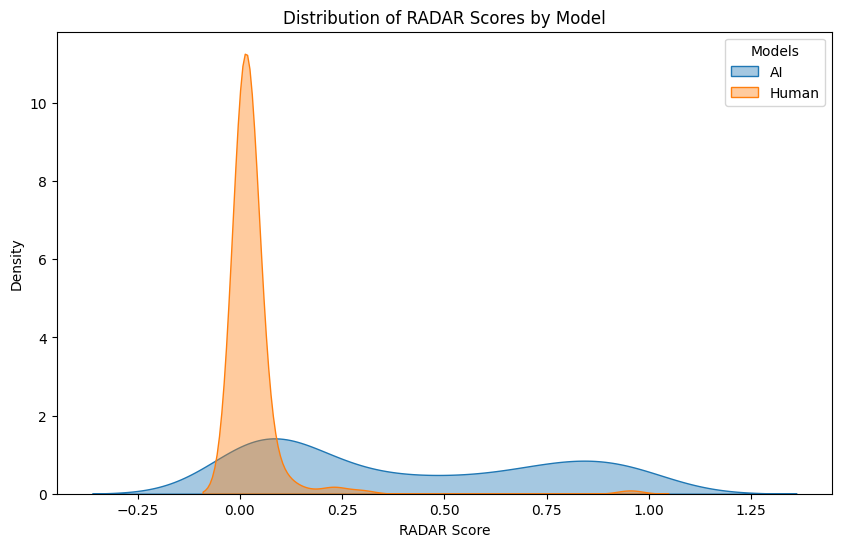

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Density")
plt.title("Distribution of RADAR Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

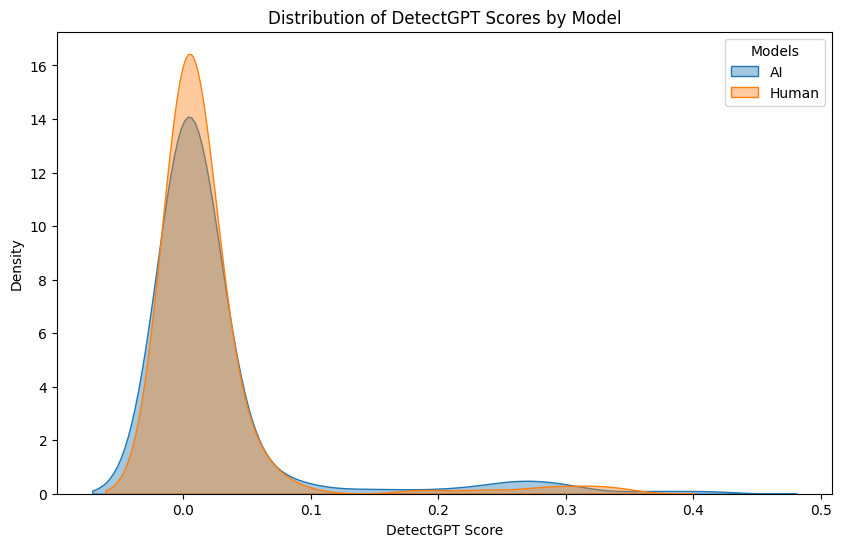

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "detectgpt_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("DetectGPT Score")
plt.ylabel("Density")
plt.title("Distribution of DetectGPT Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

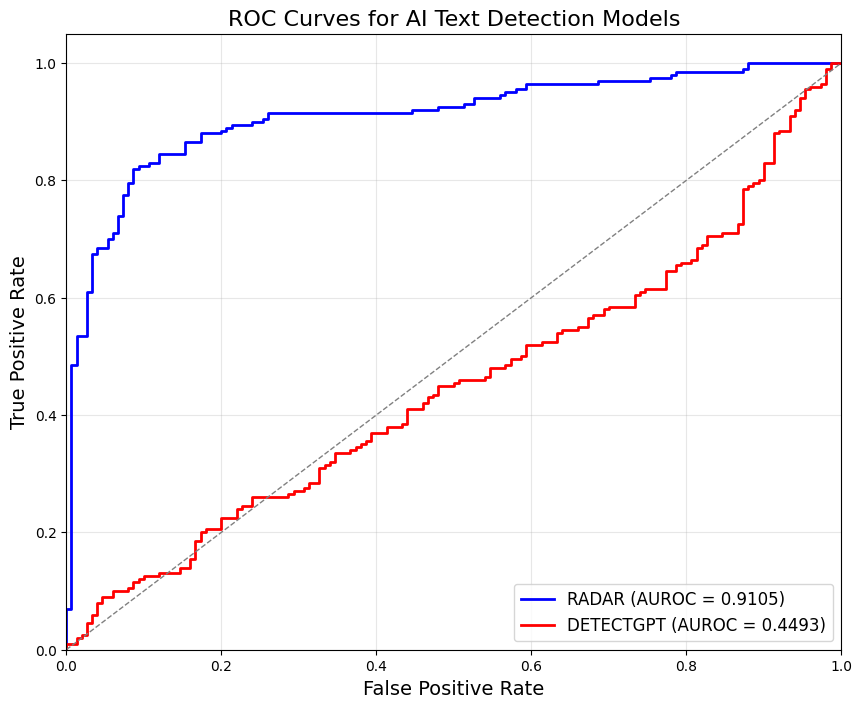

In [95]:
from sklearn.metrics import roc_curve

# Calculate ROC curve points for both detectors
fpr_radar, tpr_radar, _ = roc_curve(combined_df['label'], combined_df['radar_score'])
fpr_wild, tpr_wild, _ = roc_curve(combined_df['label'], combined_df['detectgpt_score'])

# Create a figure with appropriate size
plt.figure(figsize=(10, 8))

# Plot both ROC curves
plt.plot(fpr_radar, tpr_radar, color='blue', lw=2,
         label=f'RADAR (AUROC = {auroc_radar:.4f})')
plt.plot(fpr_wild, tpr_wild, color='red', lw=2,
         label=f'DETECTGPT (AUROC = {auroc_detectgpt:.4f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Add labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for AI Text Detection Models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

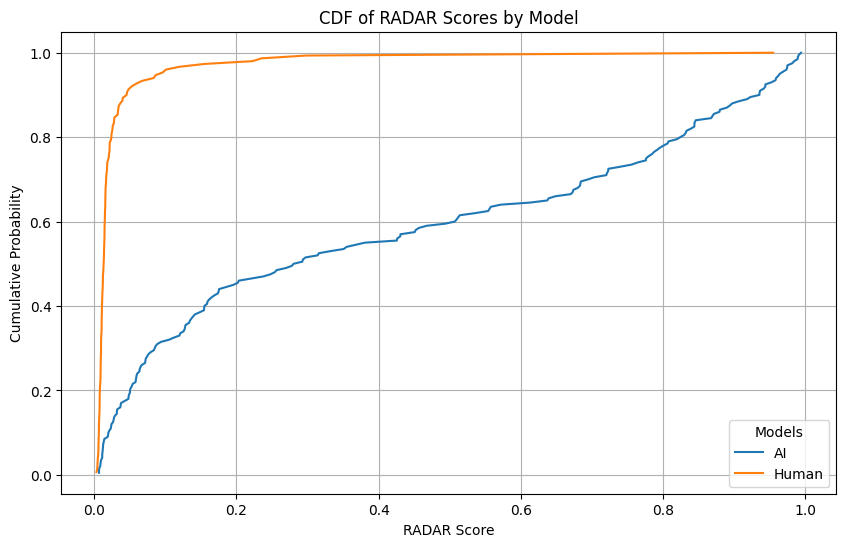

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

plt.figure(figsize=(10, 6))

# Loop through Human and AI separately
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    scores = subset[score_col].dropna()
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label=model)

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of RADAR Scores by Model")
plt.legend(title="Models")
plt.grid(True)
plt.show()


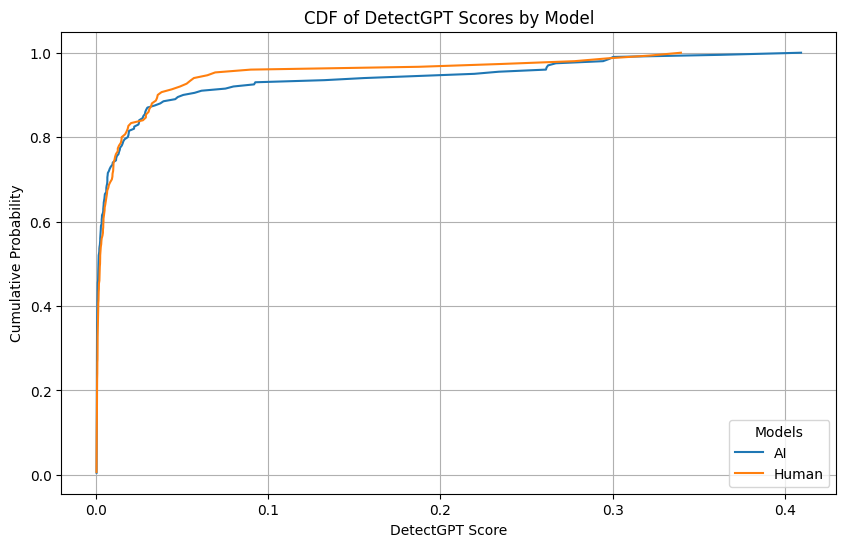

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_col = "source"
score_col = "detectgpt_score"

models = combined_df[model_col].unique()

plt.figure(figsize=(10, 6))

# Loop through Human and AI separately
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    scores = subset[score_col].dropna()
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label=model)

# Add labels and title
plt.xlabel("DetectGPT Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of DetectGPT Scores by Model")
plt.legend(title="Models")
plt.grid(True)
plt.show()
